# 09. Identify Sand Layers
For this step, we use thresholds in the Si/Al ratio of the 2 mm resolution XRF core scanning data from Babin, 2020, (Proceedings of the IODP) and core photos to identify core depths containing sand layers. We use the uncalibrated, high resolution version of the XRF data. We need the depth resolution provided by the 2mm data set to identify some of the layers present, and get the most accurate picture of the layers' thickness.  
  
It is necessary to do this step before identifying greening in the core because the sand layers sometimes contain green minerals, but might have a different origin. So we treat them separately.

## Setup
### Import Modules

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns

### Set Paths

In [48]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Volumes/SanDisk.Data/IODPU1474CorePhotos/LowRes/Raw/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'

### Import XRF and Splice Data

In [49]:
xrf=pd.read_csv(table_path+'Supplementary Table X Site U1474 2mm-2s xrf data.csv',low_memory=False,index_col='Depth CCSF (m)')
xrf['SectionLabel']=(xrf['Site']+xrf['Hole']+'_'+
                              xrf['Core'].map(str)+xrf['Type']+xrf['Section'].map(str))
xrf=xrf[xrf['In Splice']==True]
xrf=xrf[xrf.index.duplicated()==False]
xrf=xrf.sort_index()

In [50]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstructionE361.csv')
splice=splice[splice['Site']=='U1474']
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummaryU1474.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+
                              section_list['Sect'].map(str))
section_list=section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top depth CCSF (m)',
                                          'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom depth CCSF (m)'})
section_list=section_list.set_index('SectionLabel',drop=False)

sections=pd.read_csv(data_path+'SectionSummaries/spliceSectionListU1474.csv')['sectionLabel'].tolist()

### Import Core Photos and Metadata

In [51]:
cpmd=pd.read_csv(data_path+'U1474/corePhotosMetadataU1474.csv')
cpmd['SectionLabel']=cpmd['Site']+cpmd['Hole']+'_'+cpmd['Core'].map(str)+cpmd['Type']+cpmd['Sect'].map(str)
cpmd['Cropped image filename (JPEG)']=cpmd['Cropped image filename'].str[:-4]+'.jpeg'
cpmd.set_index('SectionLabel',inplace=True)
cpmd=cpmd[cpmd['Display status (T/F)']=='T']

In [52]:
phot={}
start=time.time()
for i,s in enumerate(sections):
    clear_output(wait=True)
    phot[s] = mpimg.imread(core_photos+cpmd.loc[s,'Cropped image filename'])
    
    stop=time.time()-start
    if i/len(sections)*100<2:
        expected_time='Calculating...'
    else:
        expected_time=np.round((stop-0)/(i/len(sections))/60,2)
    print('Current progress: ',np.round(i/len(sections)*100,2),'%')
    print('Current run time: ',np.round((stop-0)/60,2),' minutes')
    print('Expected run time: ',expected_time,' minutes')

Current progress:  99.54 %
Current run time:  0.01  minutes
Expected run time:  0.01  minutes


### Create DataFrame for Si/Al record

In [53]:
SiAl=pd.DataFrame(index=xrf.index)
SiAl['Depth CCSF (m)']=SiAl.index
SiAl['Si/Al']=(xrf['Si']/xrf['Al'])
SiAl['SectionLabel']=xrf['SectionLabel']
SiAl['Sand']=False

### Color Palette

In [54]:
colors=sns.color_palette('colorblind')

## Identify Sections of Interest
Here we use a rolling median filter to identify sections with spikes in the Si/Al ratio, which should indicate sand layers.

In [130]:
SiAl['RollingMedian+']=SiAl['Si/Al'].dropna().rolling(200,center=True).median()+4

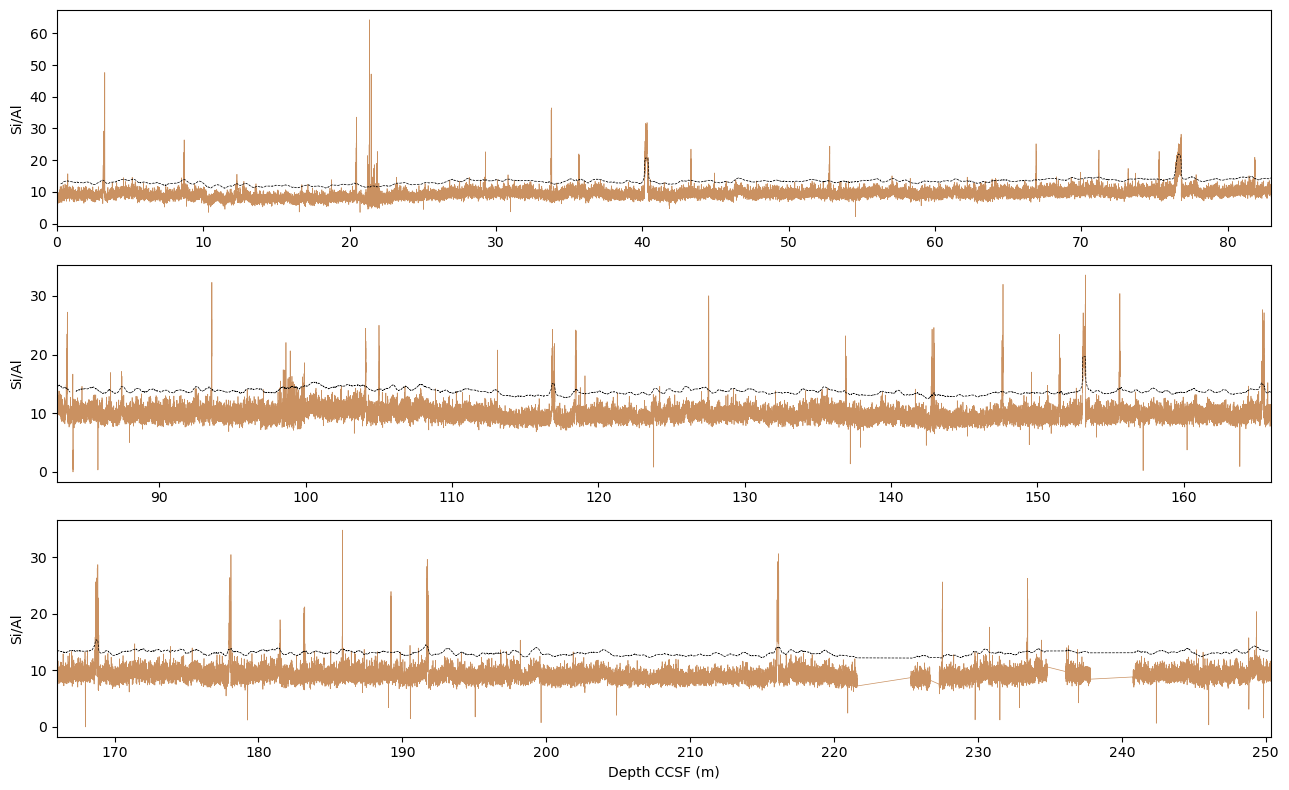

In [131]:
interval_len=int(SiAl.index.max()/3)
intervals=[(0,interval_len),(interval_len,2*interval_len),(2*interval_len,SiAl.index.max())]
fig,axes=plt.subplots(figsize=(13,8),nrows=3)
for i,ax in enumerate(axes):
    SiAl.loc[intervals[i][0]:intervals[i][1],'Si/Al'].plot(color=colors[5],lw=.5,ax=axes[i])
    SiAl['RollingMedian+'].loc[intervals[i][0]:intervals[i][1]].plot(color='k',lw=.5,ls='--',ax=axes[i])
    ax.set_ylabel('Si/Al')
    ax.set_xlim(intervals[i][0],intervals[i][1])
#     ax.axhline(13,color='k',ls='--')
    if (ax==axes[0])|(ax==axes[1]):
        ax.set_xlabel('')
plt.tight_layout()

In [134]:
counts=SiAl[SiAl['Si/Al']>SiAl['RollingMedian+']].groupby('SectionLabel')['Si/Al'].count()>2
means=SiAl[SiAl['Si/Al']>SiAl['RollingMedian+']].groupby('SectionLabel').mean(numeric_only=True)
SOI=means[counts].sort_values(by='Depth CCSF (m)').index.unique().tolist()

In [135]:
len(SOI)

54

## Thresholding Function
This script will allow you to check the Si/Al and the core photo of any core.

In [247]:
sand_layers=pd.DataFrame()
sand_layers['Sand>']=None
sand_layers['Top depth CCSF (m)']=None
sand_layers['Bottom depth CCSF (m)']=None

In [248]:
def thresh(number,threshold):
    sect=SOI[number]
    
    ### Set up axis
    fig=plt.figure(figsize=(14,4))
    gs = gridspec.GridSpec(3, 1, figure=fig,hspace=.1,left=.05,right=.95,top=.95)
    ax1=fig.add_subplot(gs[0,:])
    ax2=fig.add_subplot(gs[1:3,:])
    
    ### Title
    ax1.set_title('Hole '+sect[5]+' Core '+sect[7:],
                  fontweight='bold',fontsize=20,pad=0,loc='left')
    
    ### Data Management
    cols=['Si/Al','RollingMedian+']
    data=SiAl.loc[SiAl['SectionLabel']==sect,cols]
    SiAl.loc[data.index,'Sand>']=False
    top,bottom=section_list.loc[sect,['Top depth CCSF (m)','Bottom depth CCSF (m)']]
    pxl_m=np.array(phot[sect]).shape[1]/section_list.loc[sect,'Recovered length (m)']
    
    ### Image plot
    ax1.imshow(phot[sect])
    ax1.axis('off')
    
    ### Data plot
    data['Si/Al'].plot(ax=ax2,marker='o',ms=3,color=colors[5])
    data['RollingMedian+'].plot(ax=ax2,color='k',ls='--',lw=.5)
    ax2.set_ylim(4,50)
    ax2.axhline(threshold,color=colors[5])
    
    ### Data Processing
    potential=data[data>threshold]
    potential['Depth']=potential.index
    potential=potential.dropna().copy()
    if potential.shape[0]==0:
        for i,a in enumerate([ax2]):
            a.set_ylabel(cols[i])
            a.set_xlim(top,bottom)
            ax2.set_xlabel('Depth (m CCSF)')
        plt.show()
        return print('No sound found with this threshold')
    sandzone=potential[potential['Depth']-potential['Depth'].shift()<=.004]
    sandtop=sandzone.index[0]-.01
    sandbottom=sandzone.index[-1]+.01
    sands=data.loc[sandtop:sandbottom].index
    
    ### Coloring
    ax1.axvline((sandtop-top)*pxl_m,c='w')
    ax1.axvline((sandbottom-top)*pxl_m,c='w')
    ax2.axvspan(xmin=sandtop,xmax=sandbottom,color=colors[5],alpha=.5)

        
    ### Axis management
    for i,a in enumerate([ax2]):
        a.set_ylabel(cols[i])
        a.set_xlim(top,bottom)
    ax2.set_xlabel('Depth (m CCSF)')
    
    ### Save Results
    sand_layers.loc[sect,['Sand>','Top depth CCSF (m)','Bottom depth CCSF (m)']]=[threshold,sandtop,sandbottom]

## Threshold for Sand
This will go through the sections identified by the rolling median filter. For each section, we'll introduce a cutoff threshold above which the depths are classified as sand.

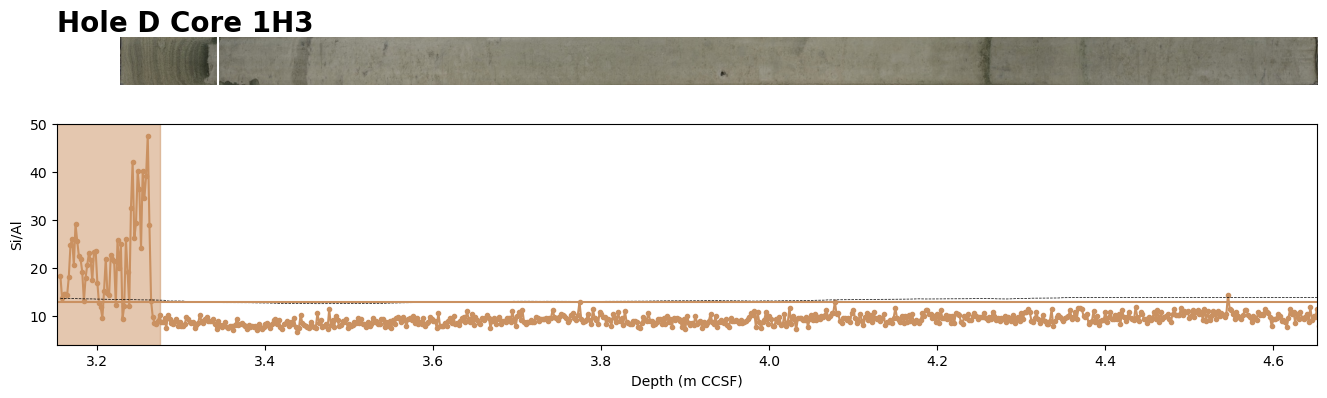

In [249]:
thresh(0,13)

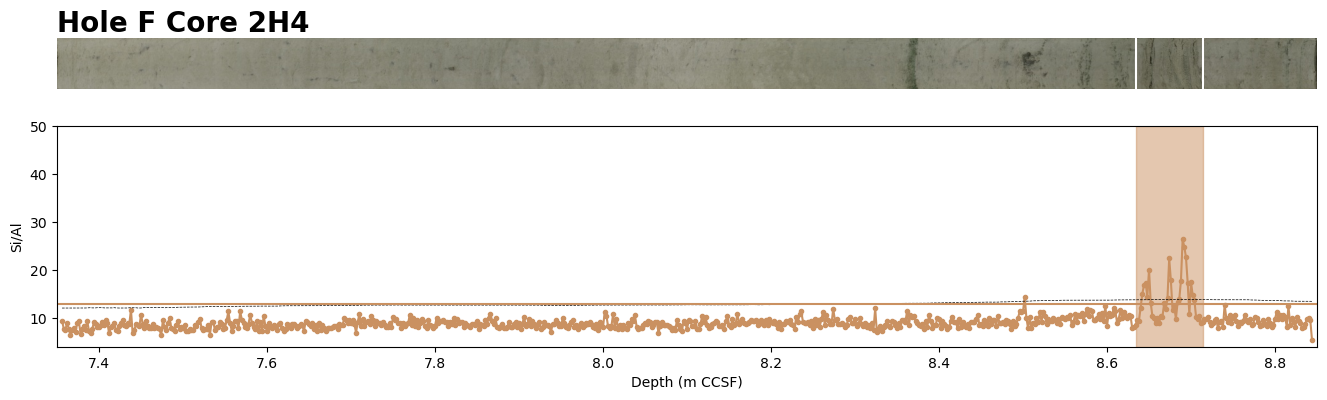

In [250]:
thresh(1,13)

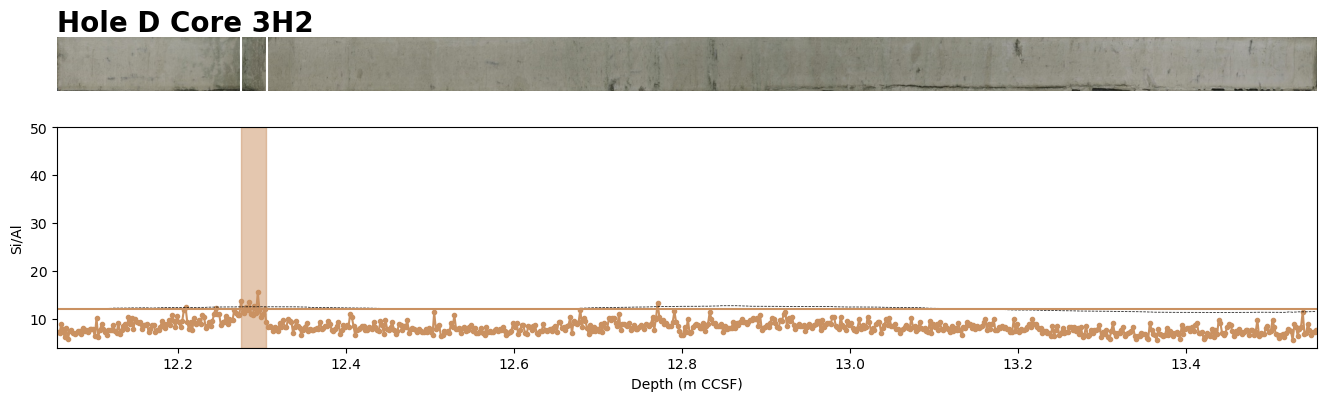

In [251]:
thresh(2,12)

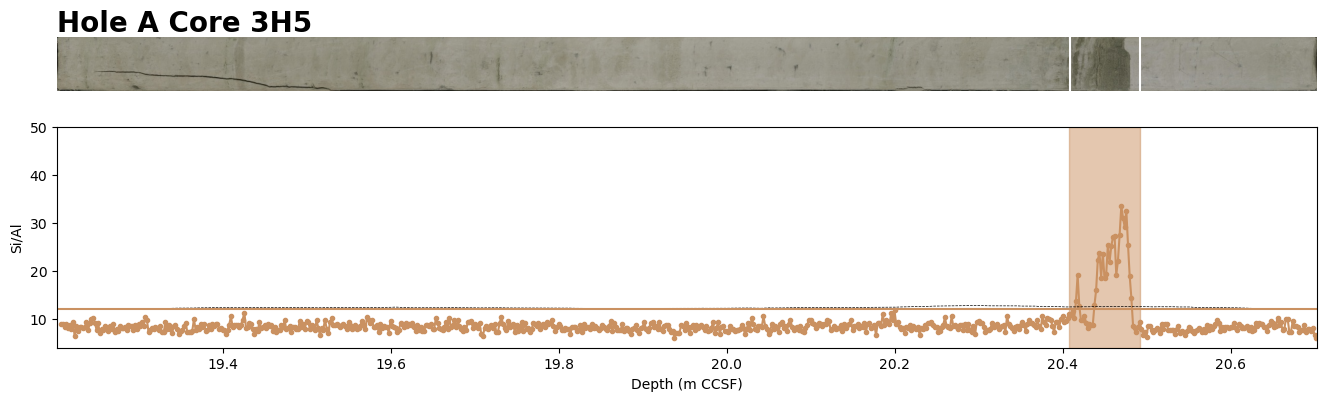

In [252]:
thresh(3,12)

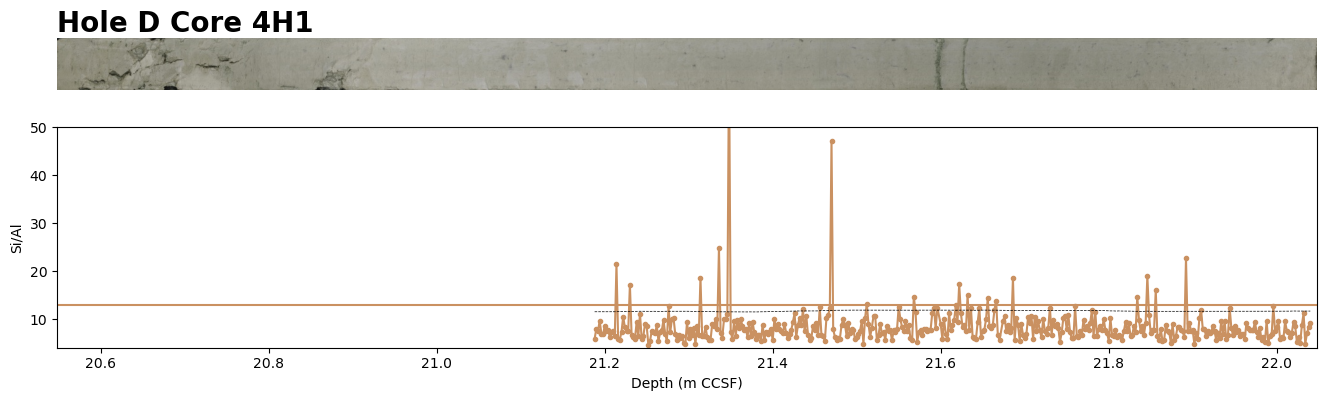

No sound found with this threshold


In [253]:
thresh(4,13)

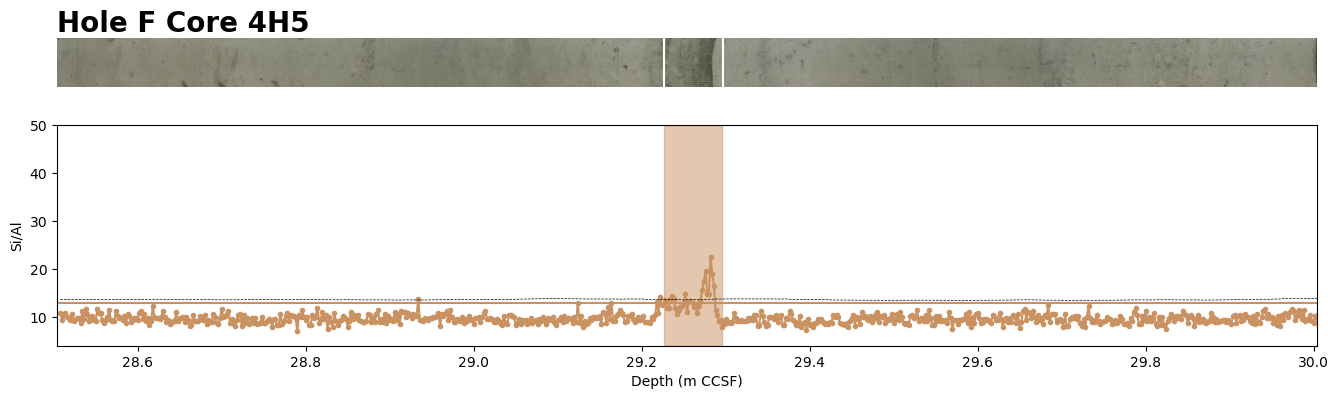

In [254]:
thresh(5,13)

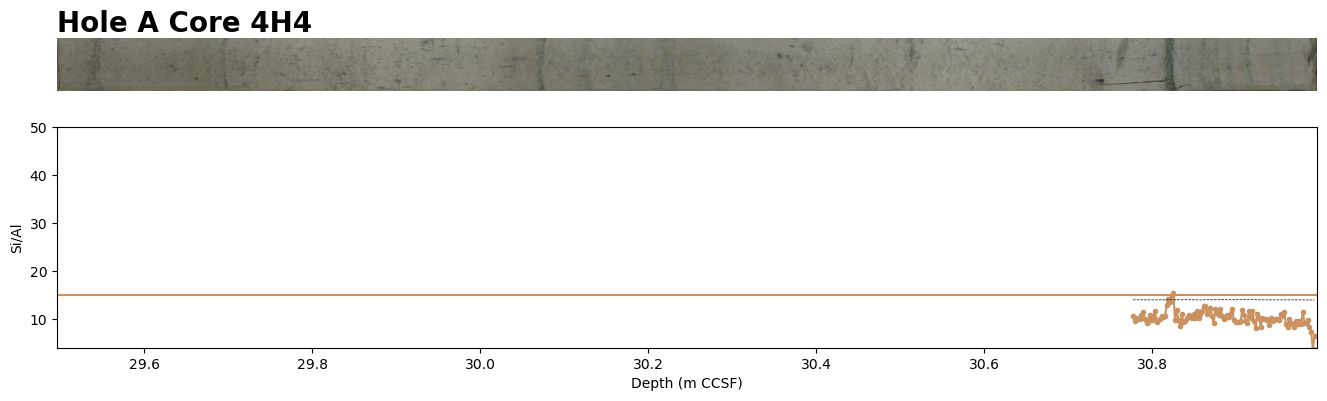

No sound found with this threshold


In [255]:
thresh(6,15)

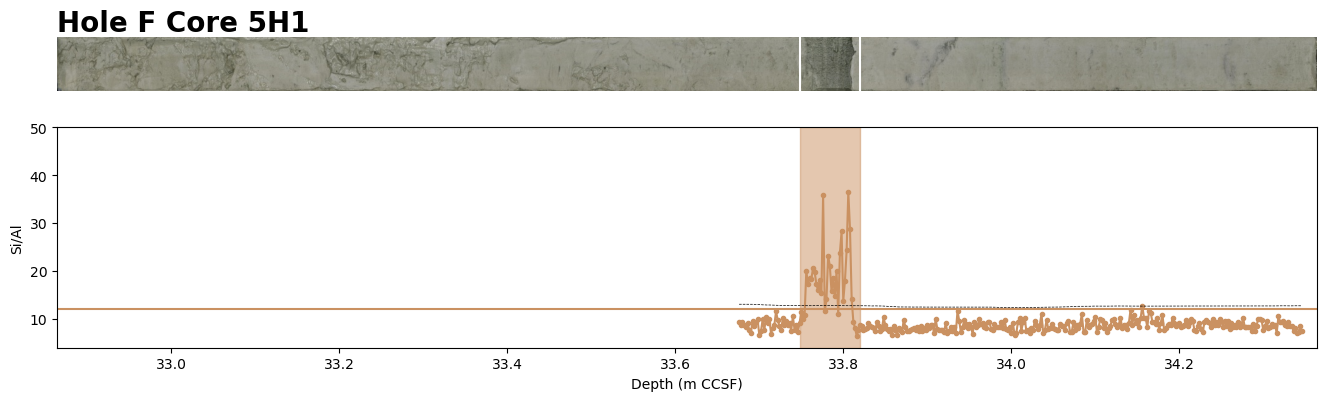

In [256]:
thresh(7,12)

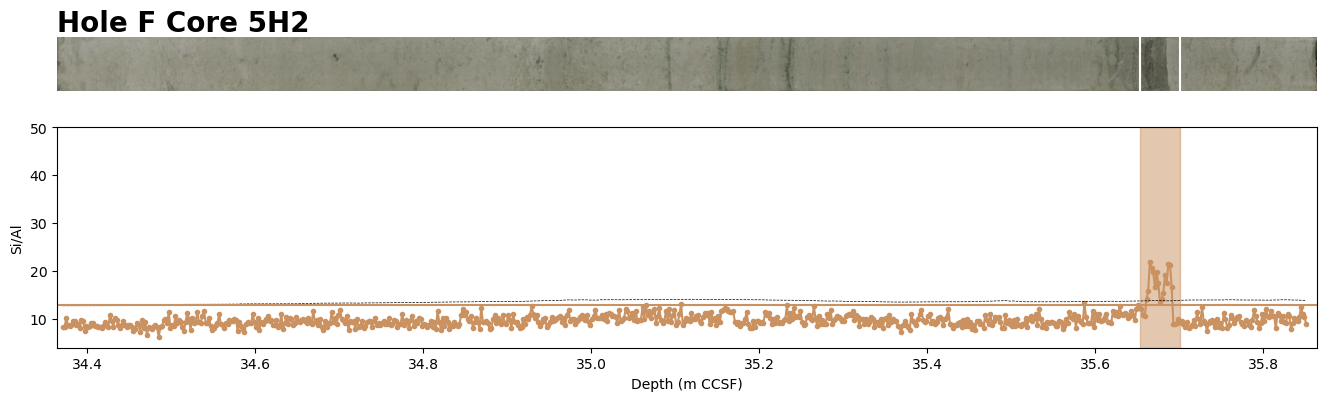

In [257]:
thresh(8,13)

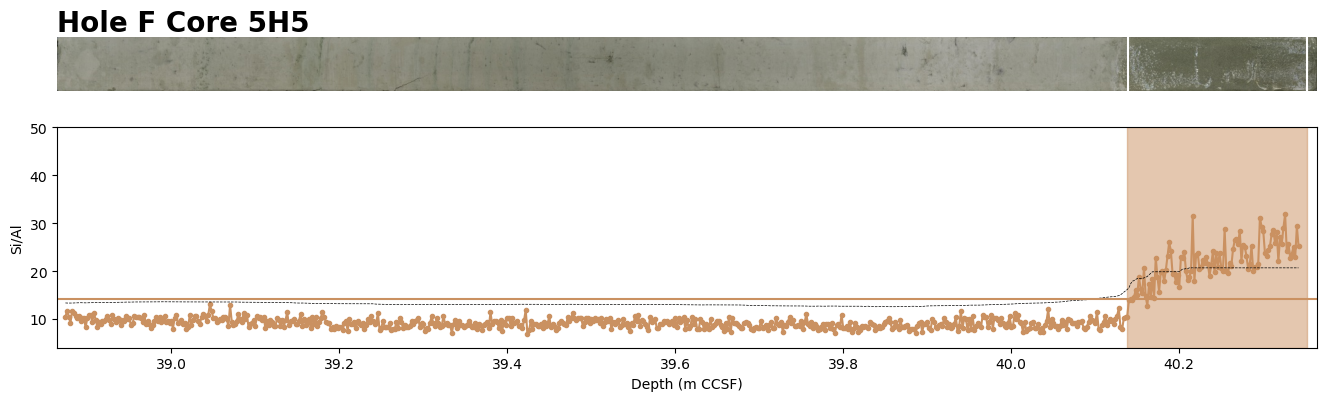

In [258]:
thresh(9,14.25)

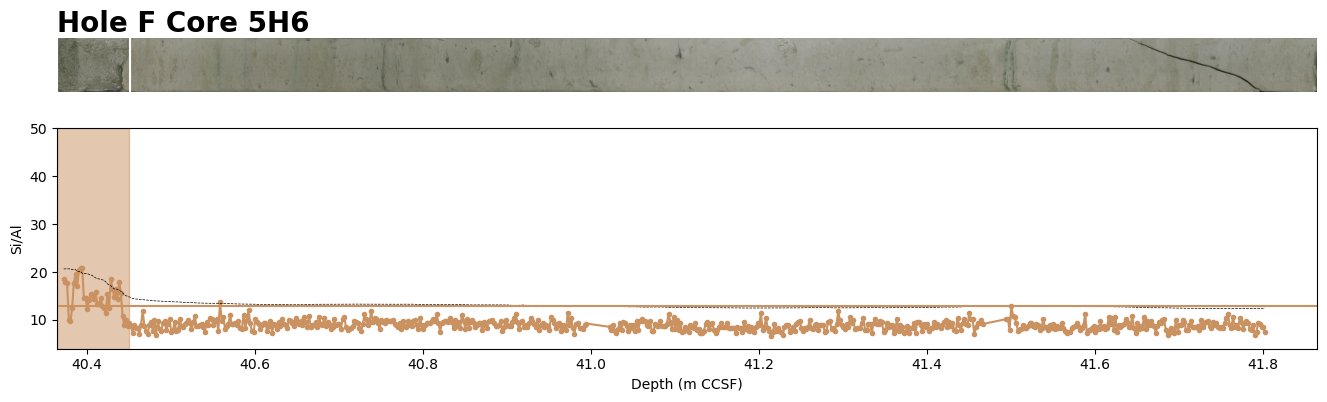

In [259]:
thresh(10,13)

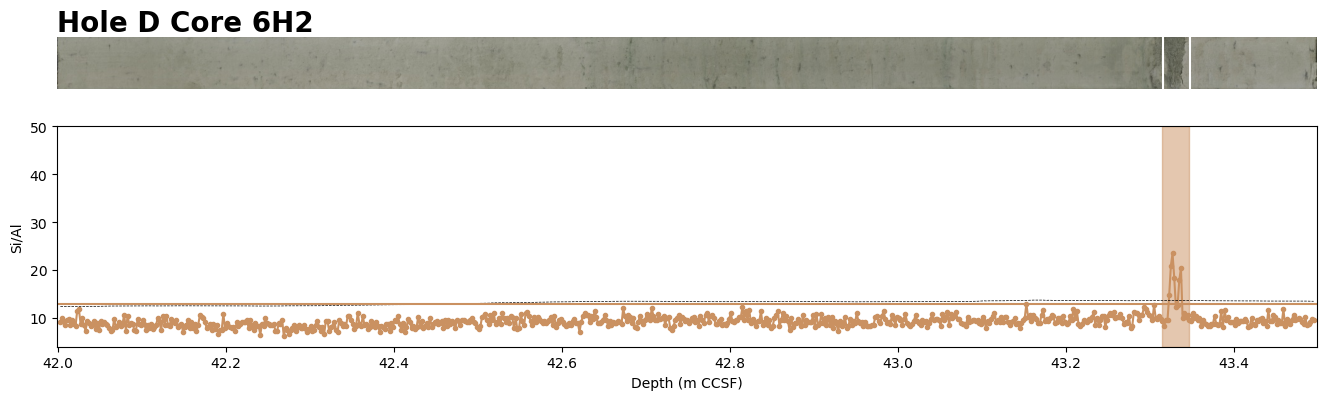

In [260]:
thresh(11,13)

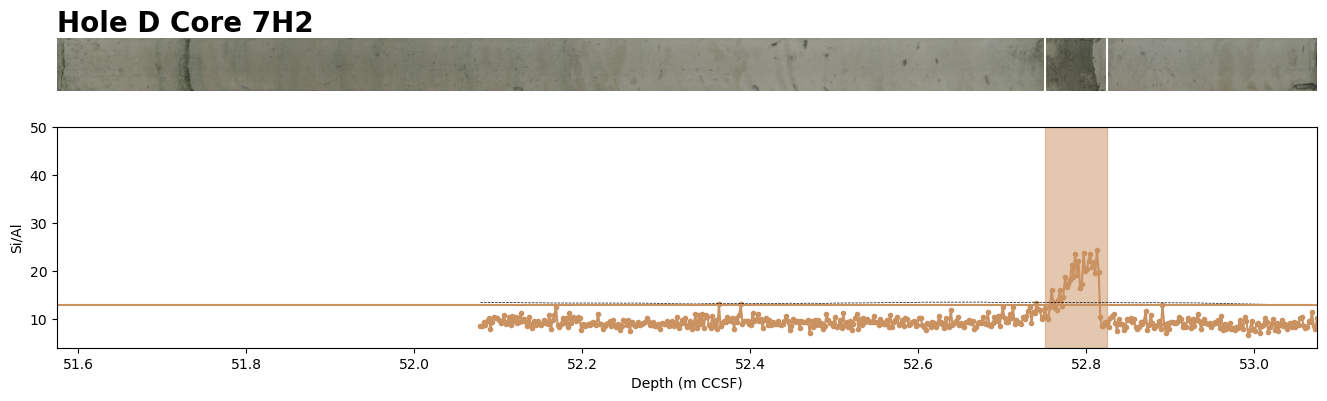

In [261]:
thresh(12,13)

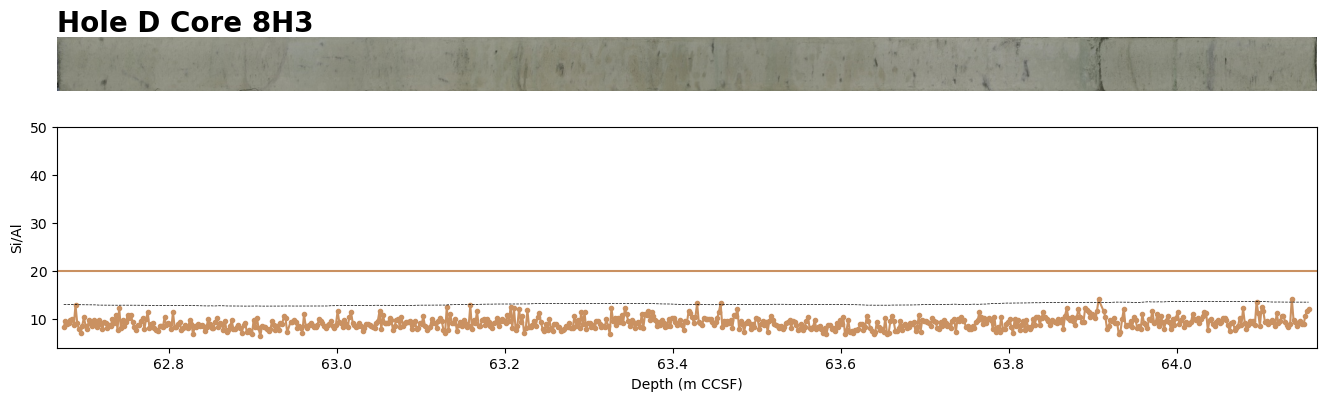

No sound found with this threshold


In [262]:
thresh(13,20)

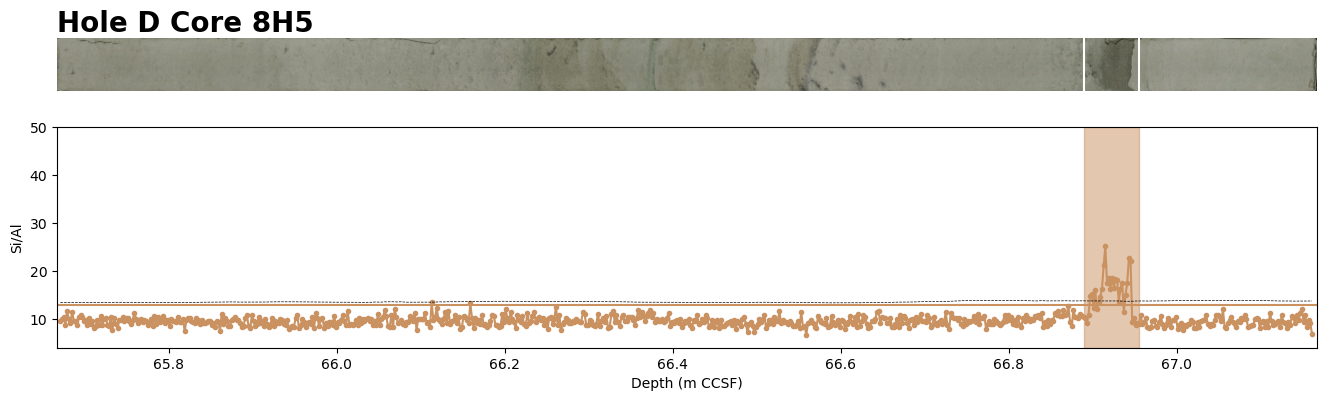

In [263]:
thresh(14,13)

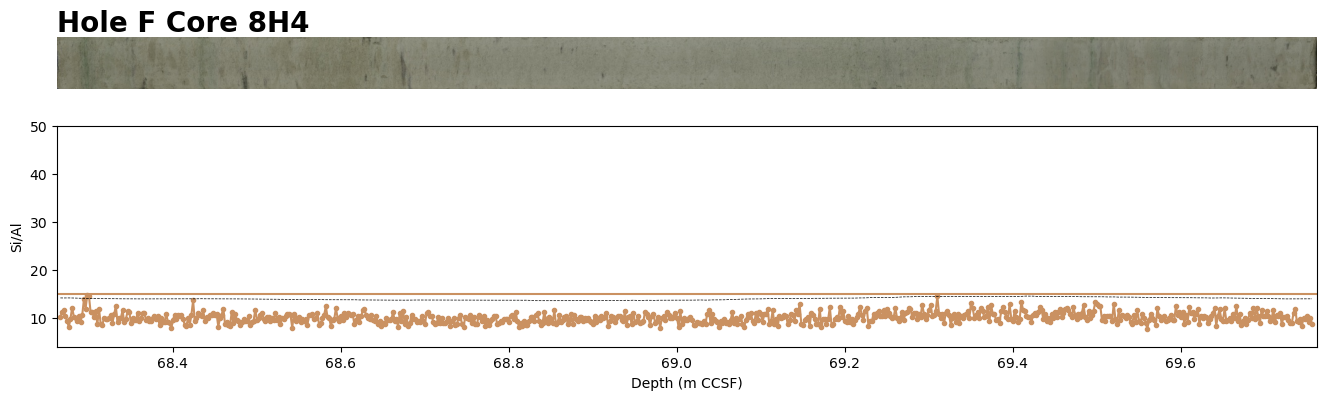

No sound found with this threshold


In [264]:
thresh(15,15)

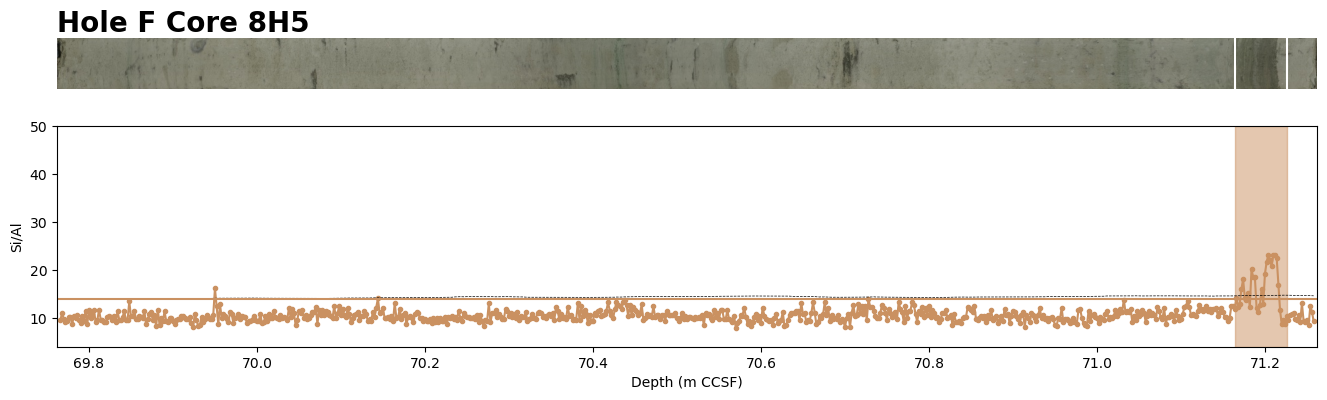

In [265]:
thresh(16,14)

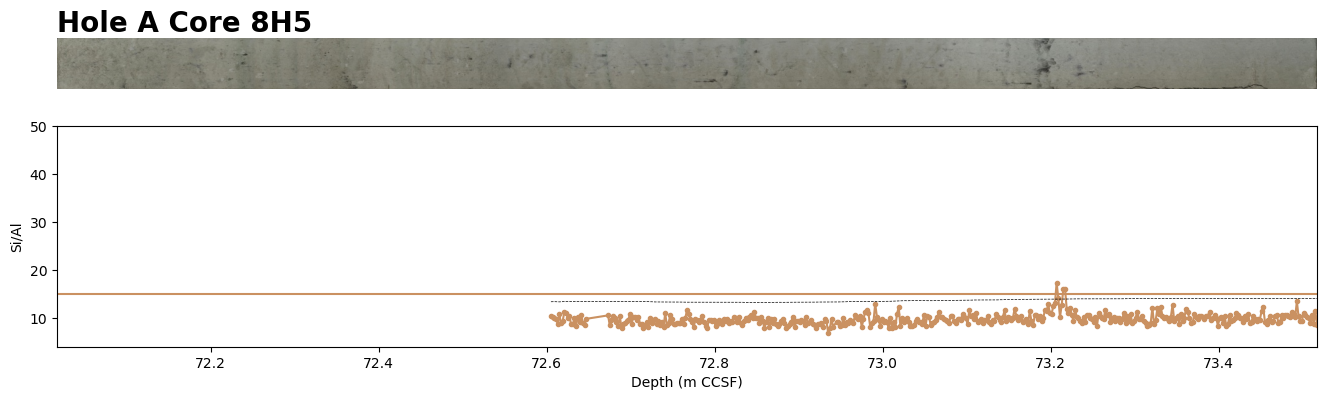

No sound found with this threshold


In [266]:
thresh(17,15)

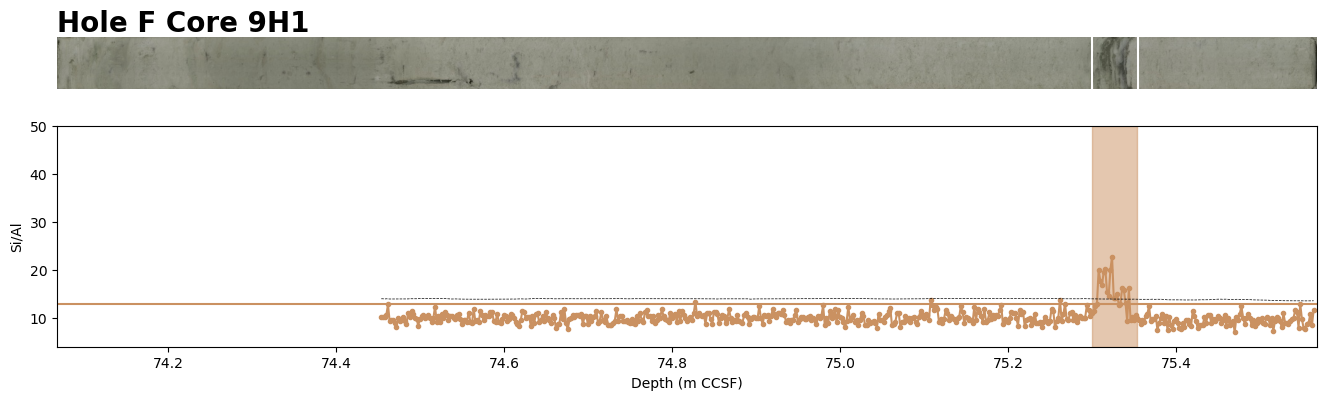

In [267]:
thresh(18,13)

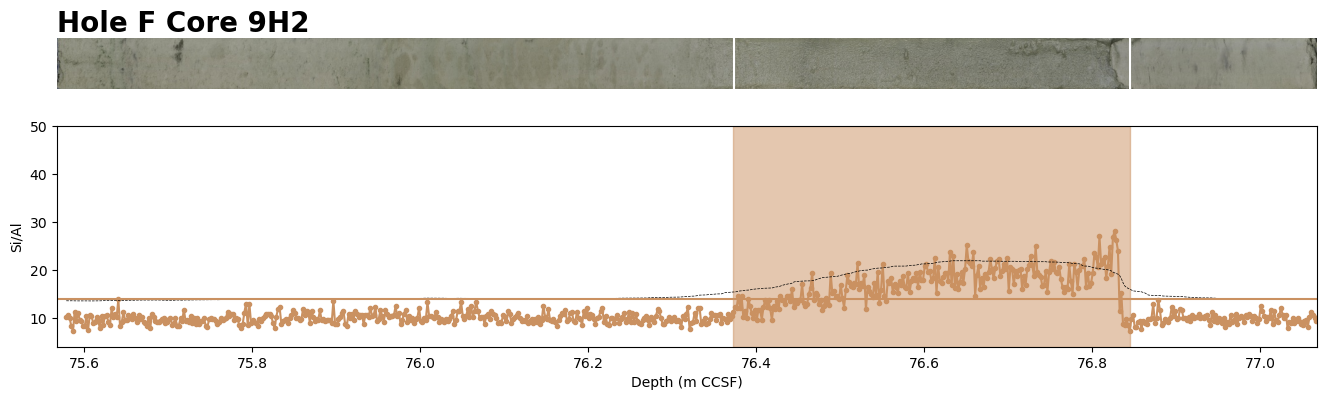

In [268]:
thresh(19,14)

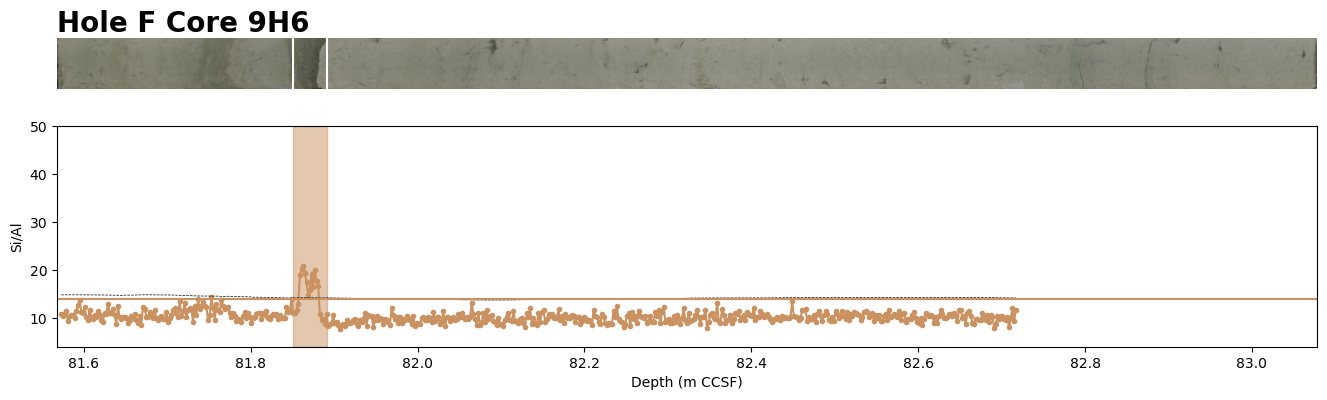

In [269]:
thresh(20,14)

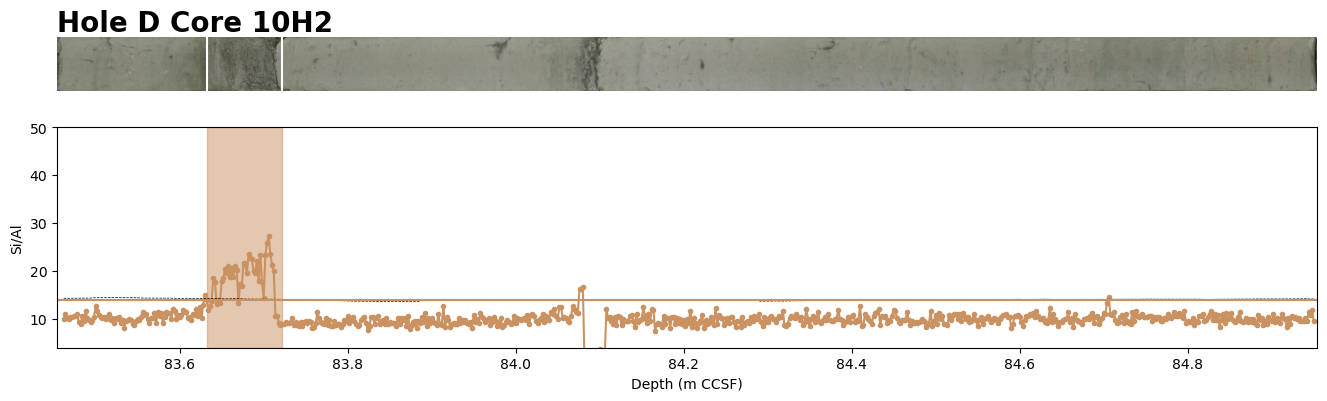

In [270]:
thresh(21,14)

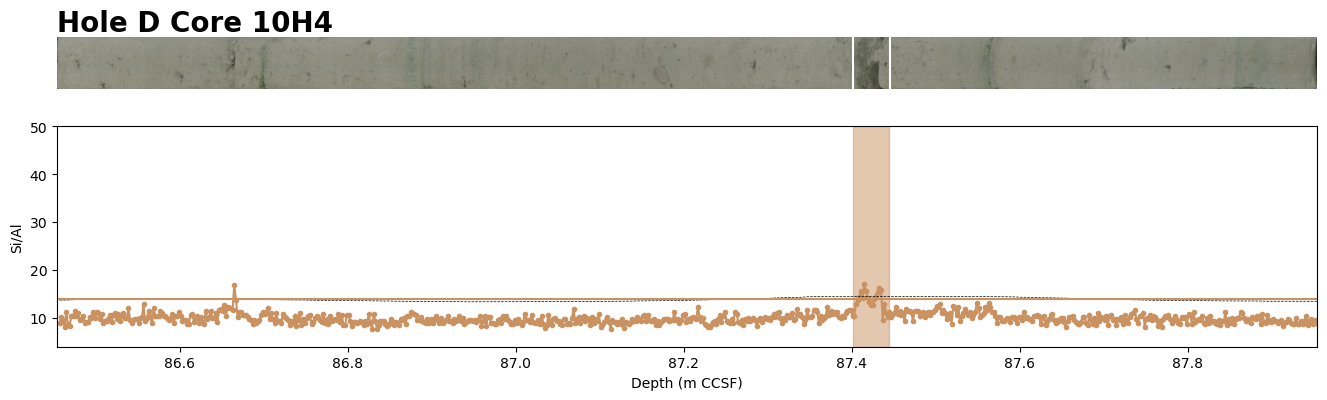

In [271]:
thresh(22,14)

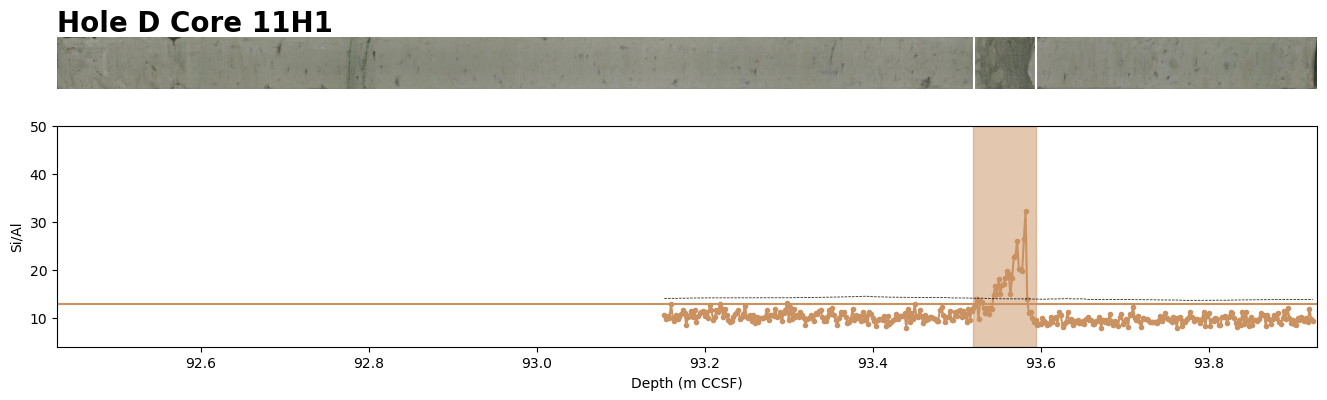

In [272]:
thresh(23,13)

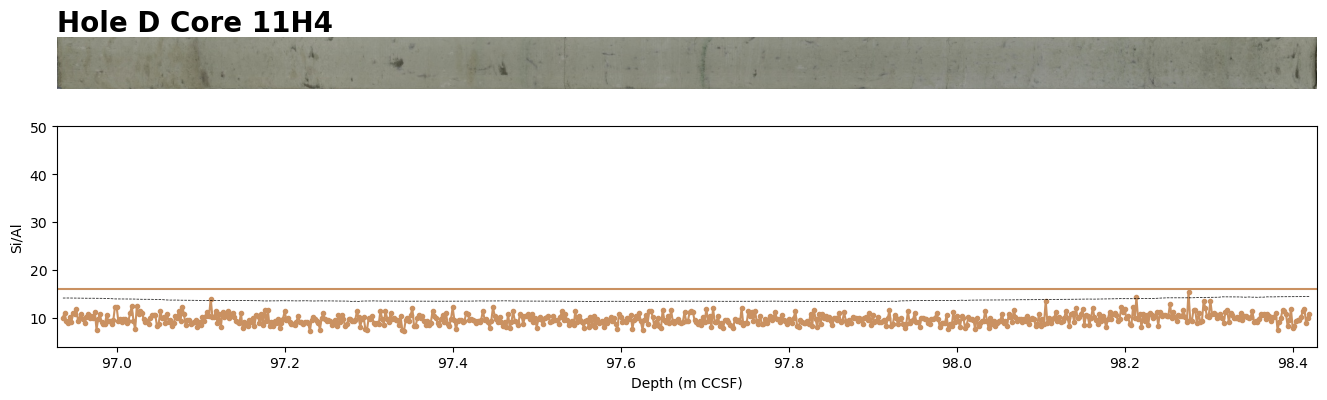

No sound found with this threshold


In [273]:
thresh(24,16)

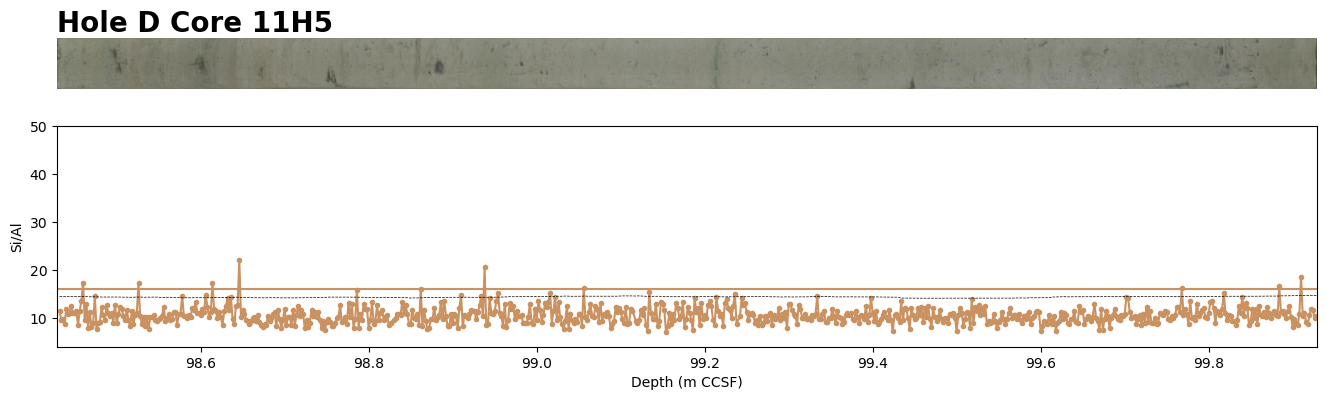

No sound found with this threshold


In [274]:
thresh(25,16)

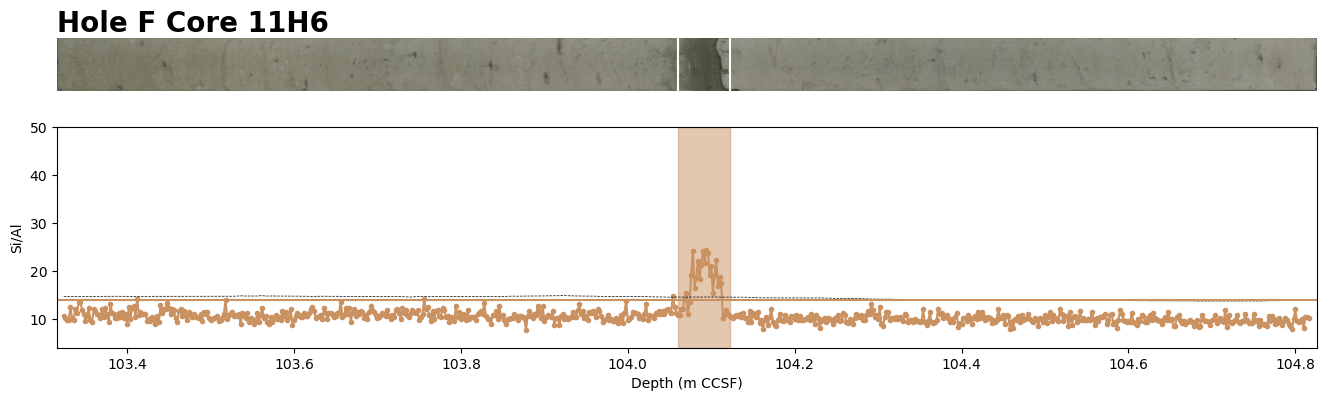

In [275]:
thresh(26,14)

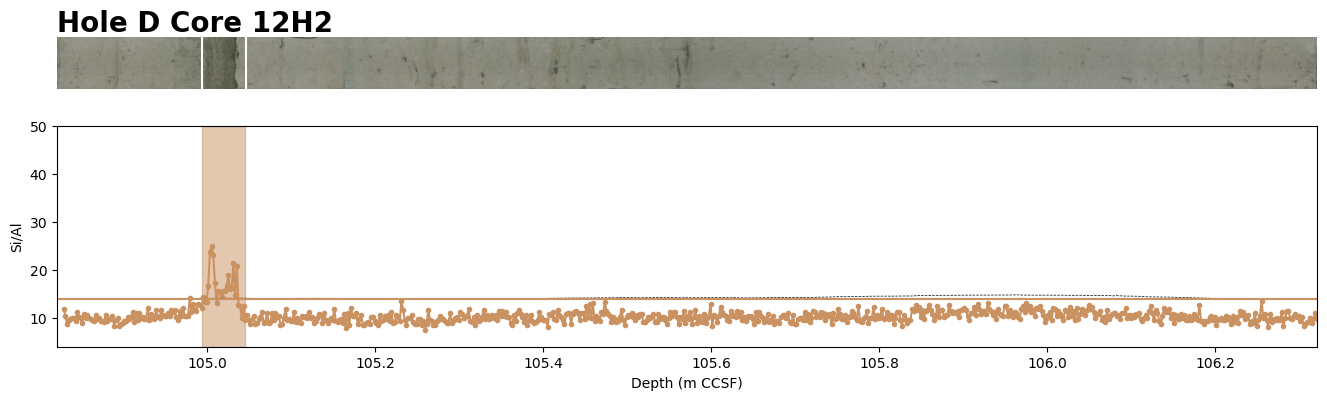

In [276]:
thresh(27,14)

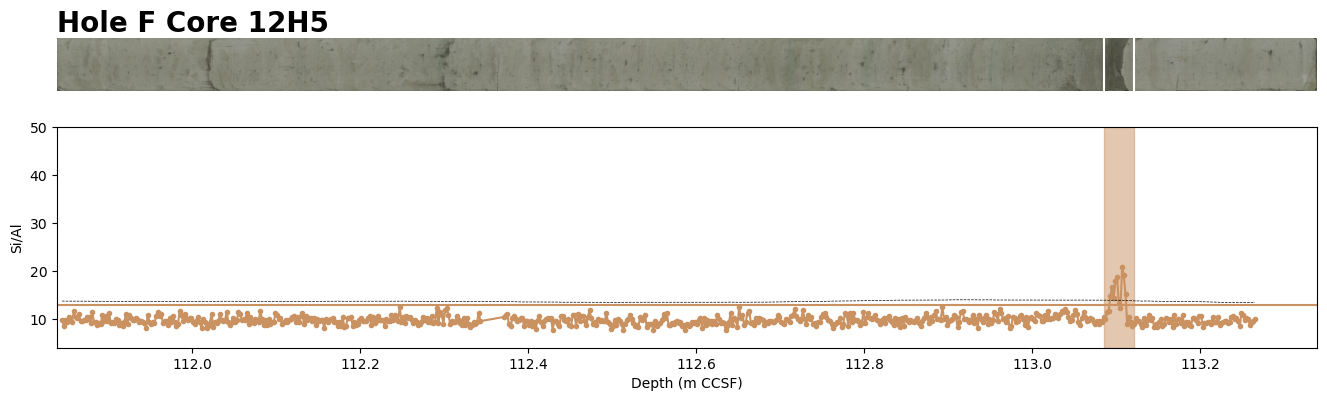

In [277]:
thresh(28,12.9)

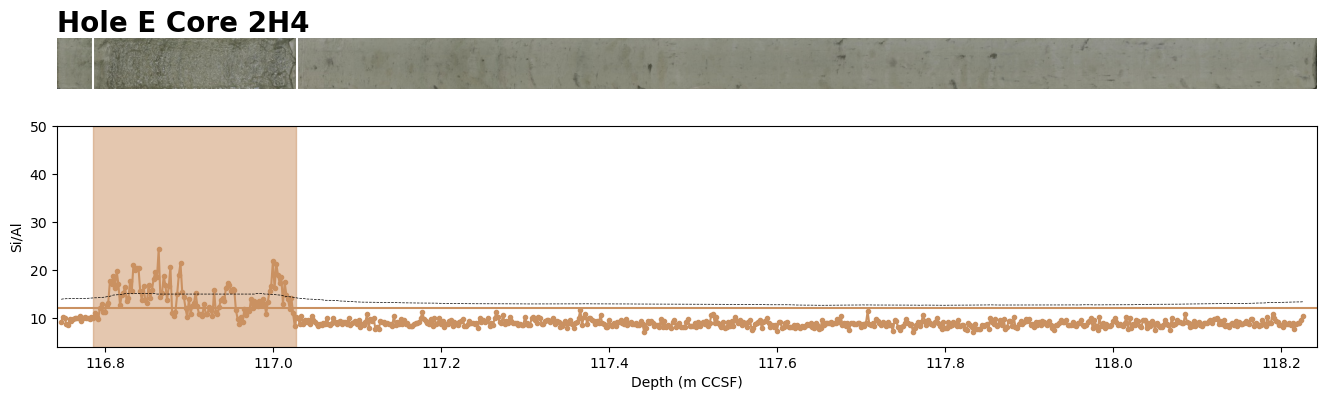

In [278]:
thresh(29,12)

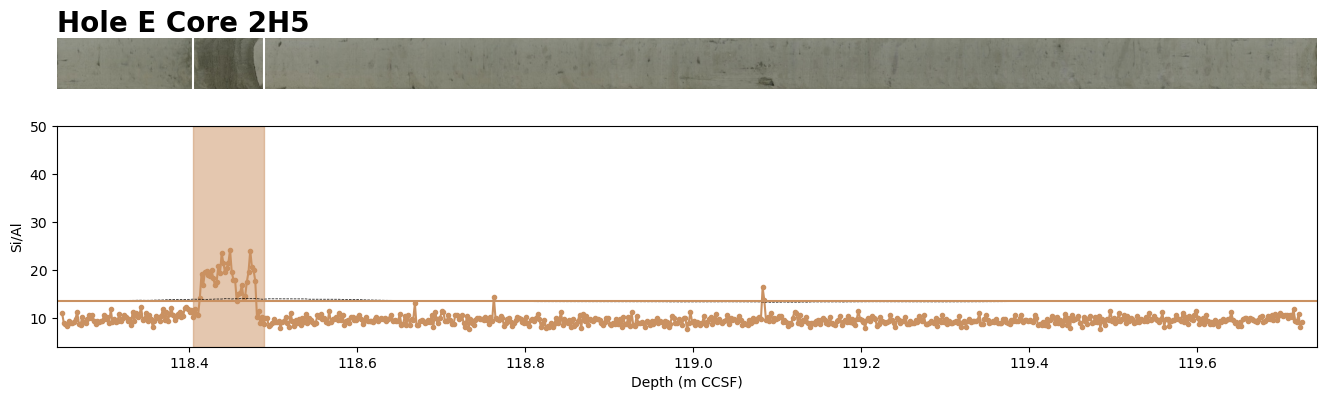

In [279]:
thresh(30,13.5)

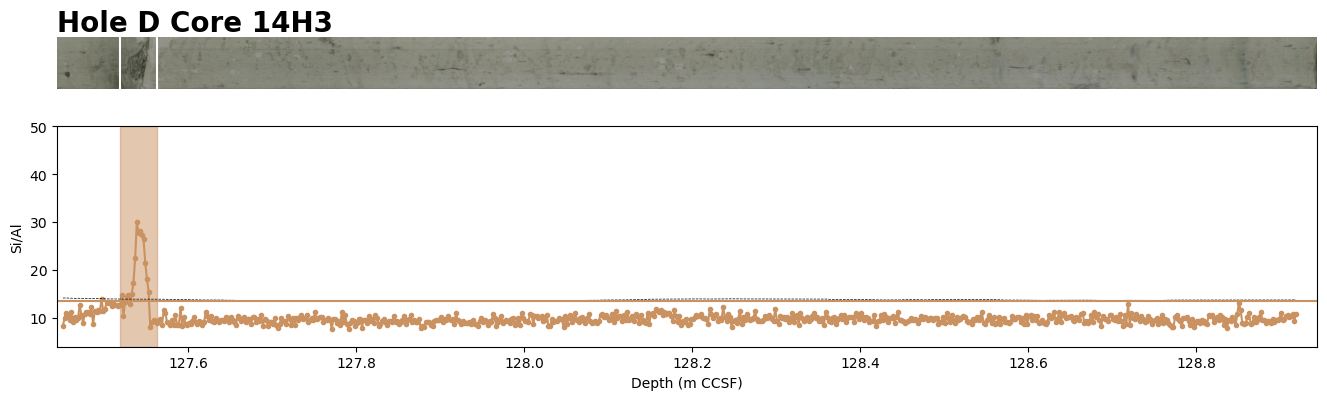

In [280]:
thresh(31,13.5)

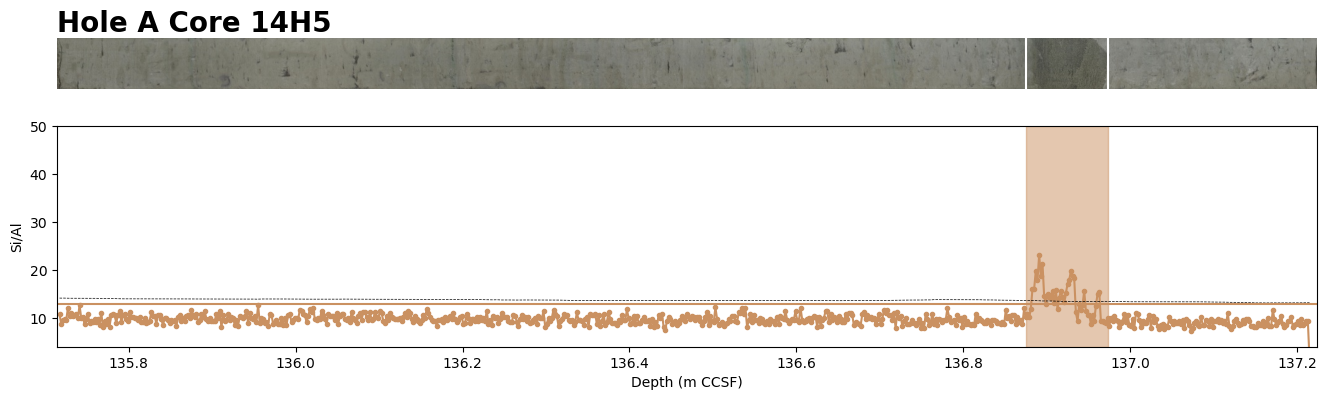

In [281]:
thresh(32,13)

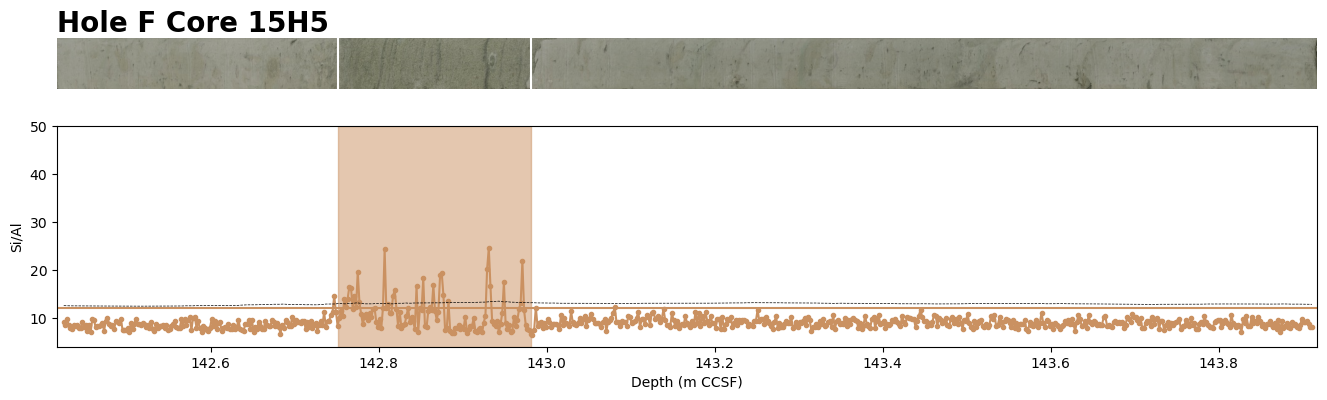

In [282]:
thresh(33,12)

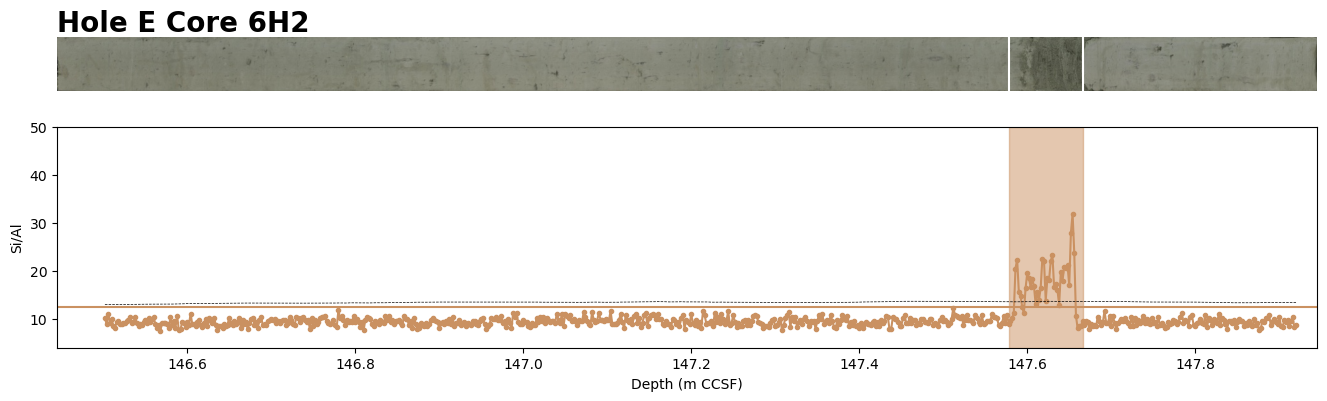

In [283]:
thresh(34,12.5)

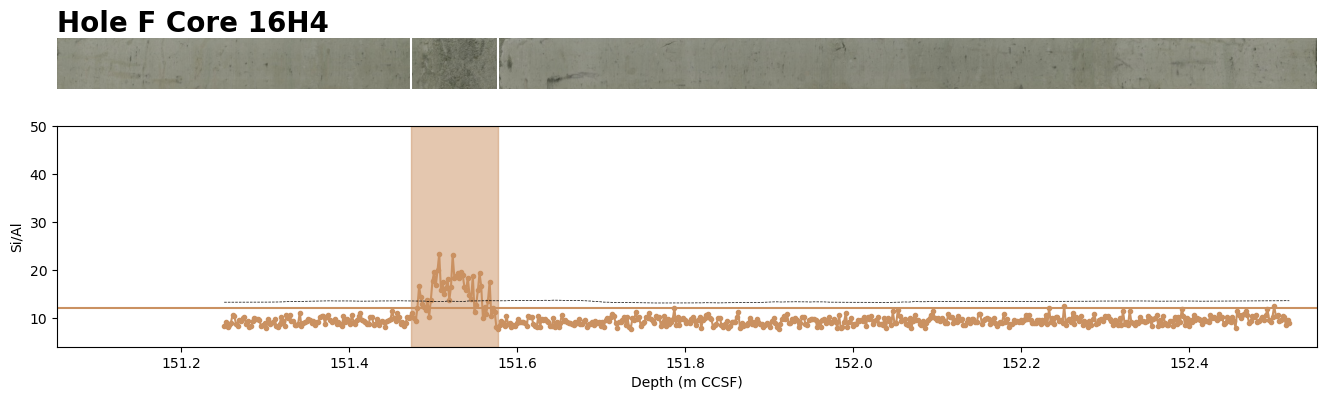

In [284]:
thresh(35,12)

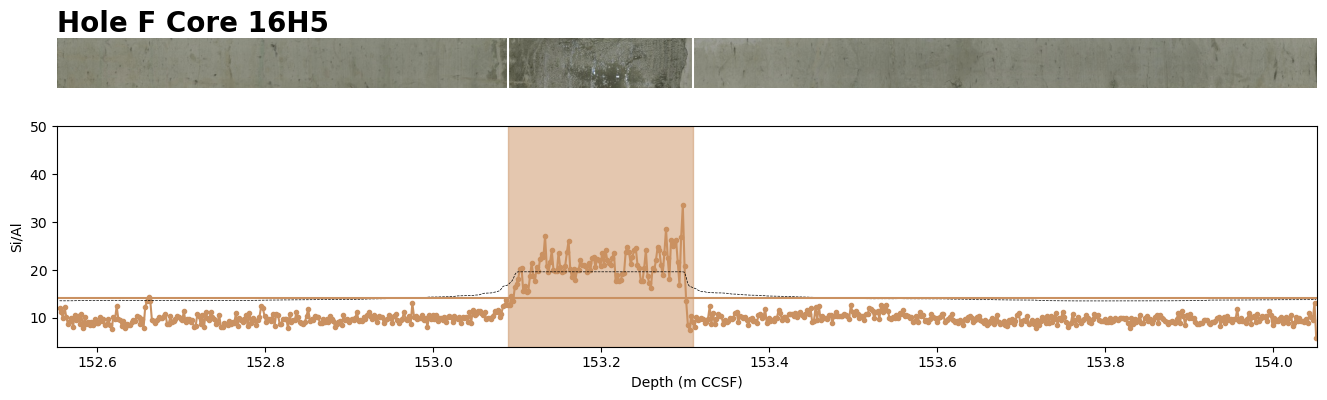

In [285]:
thresh(36,14.1)

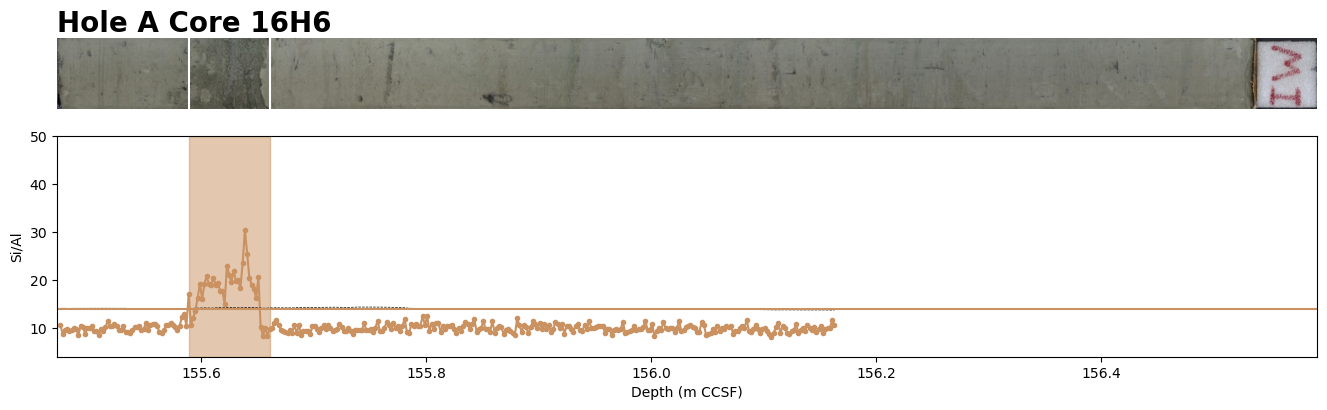

In [286]:
thresh(37,14)

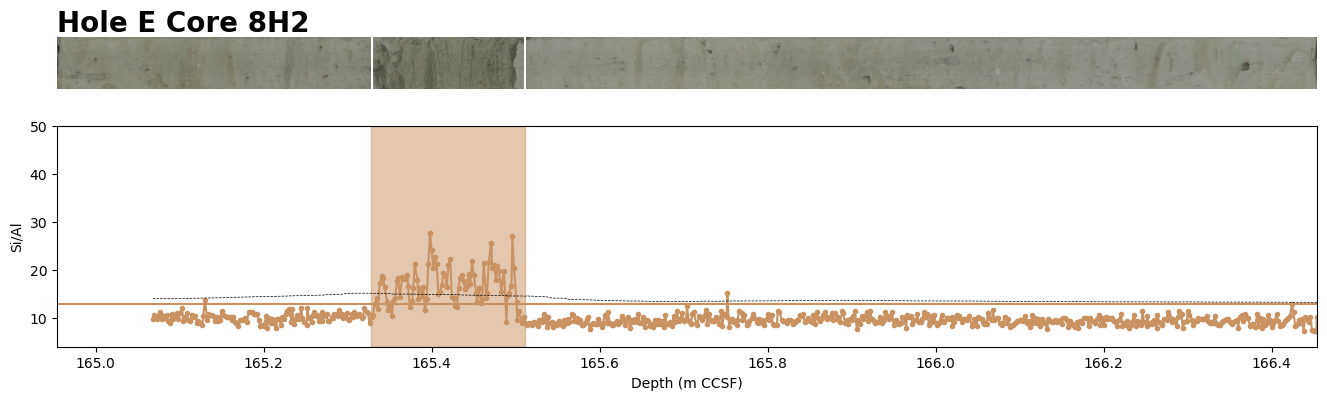

In [287]:
thresh(38,13)

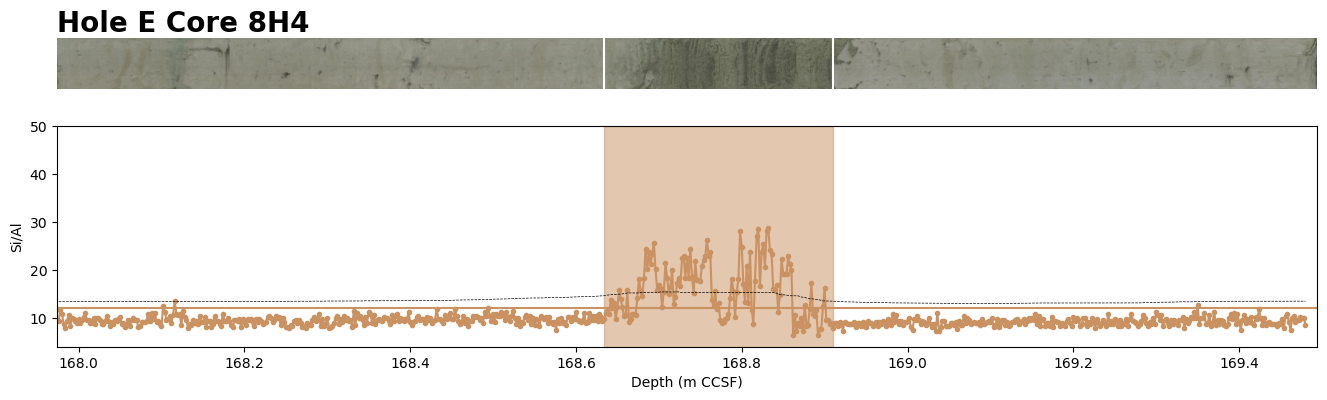

In [288]:
thresh(39,12)

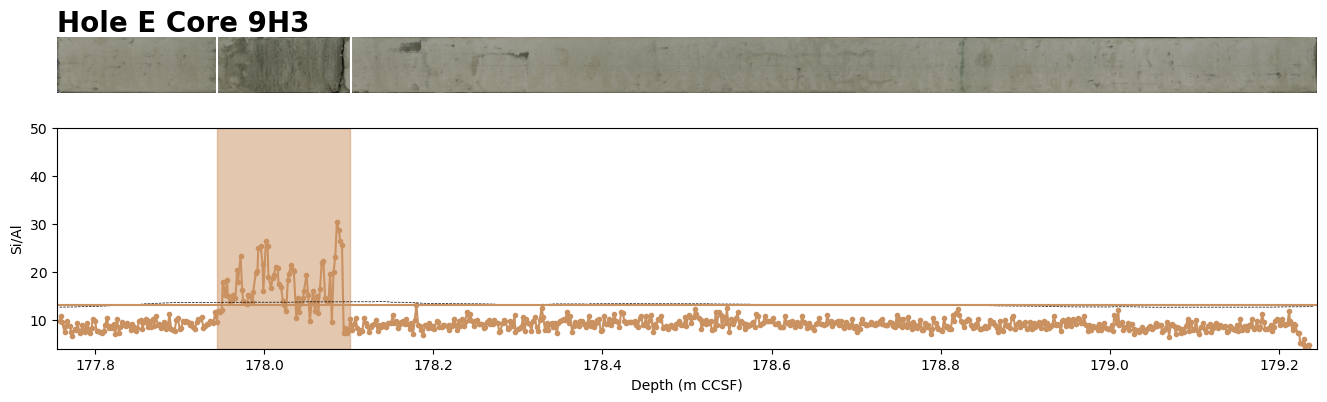

In [289]:
thresh(40,13.2)

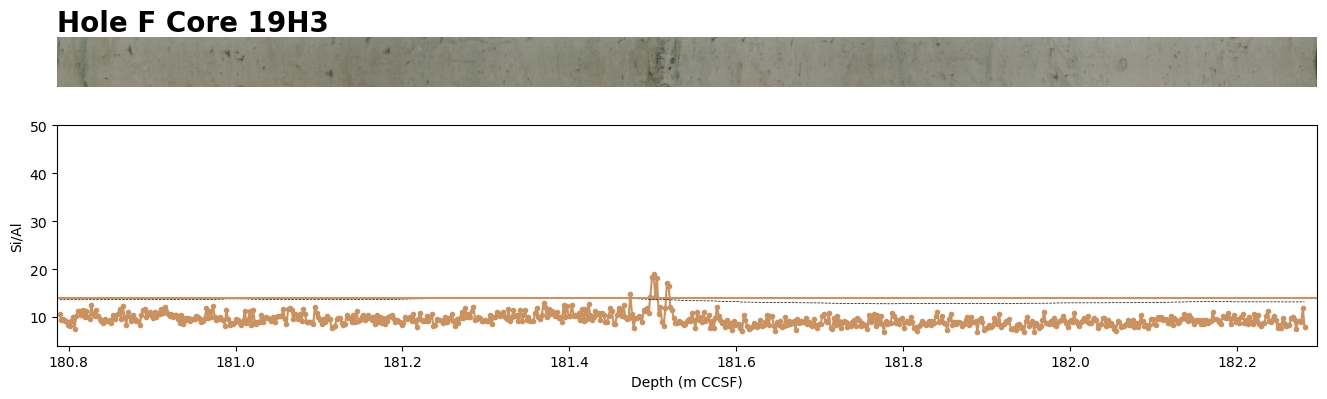

No sound found with this threshold


In [290]:
thresh(41,14)

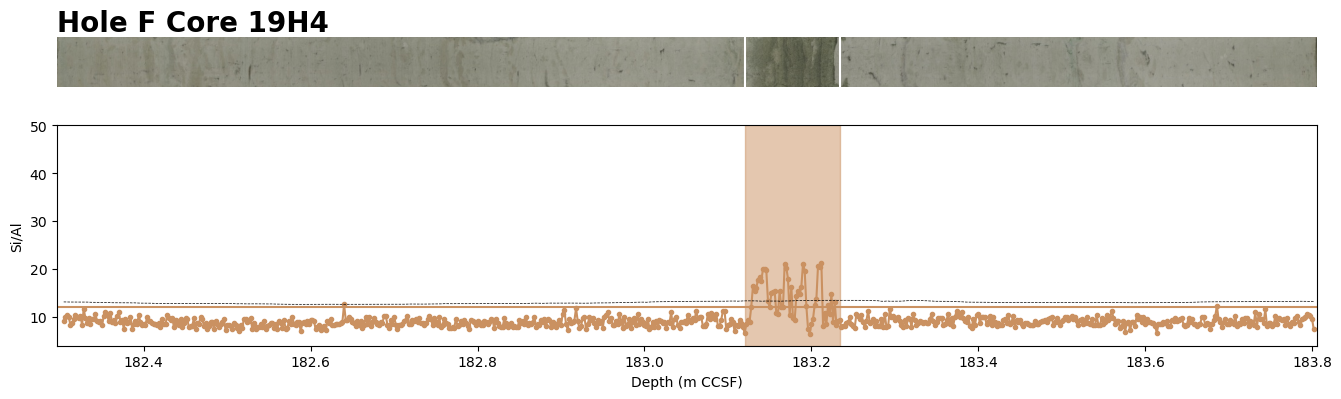

In [291]:
thresh(42,12)

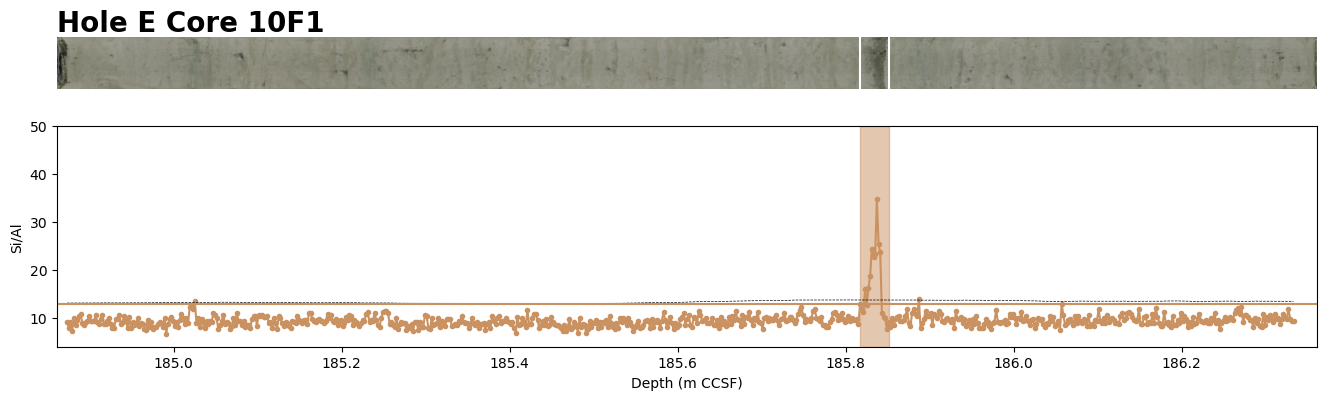

In [292]:
thresh(43,13)

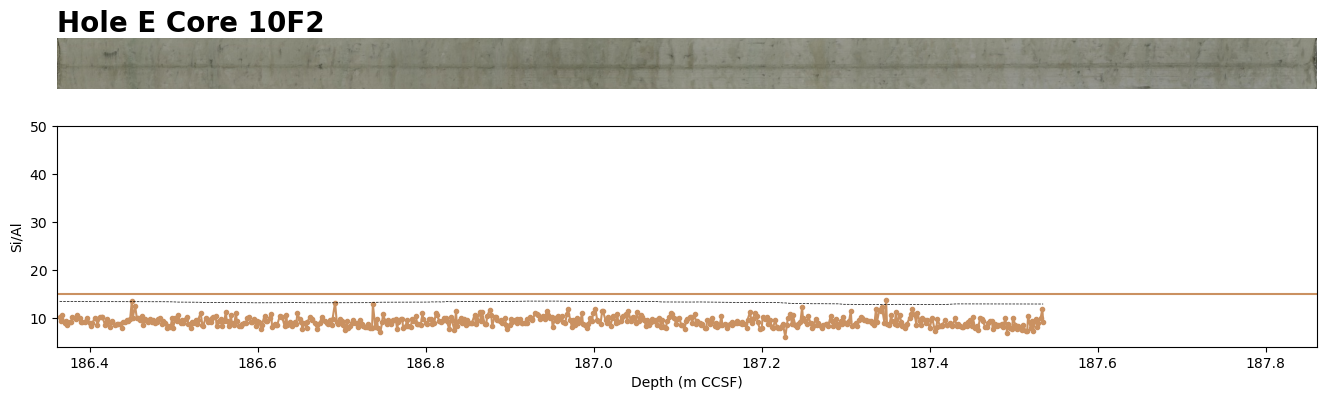

No sound found with this threshold


In [293]:
thresh(44,15)

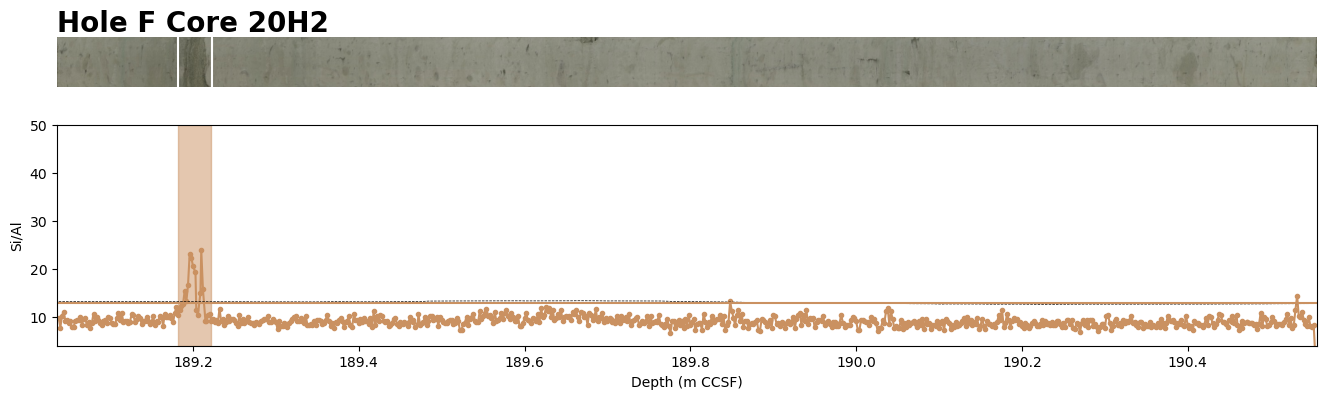

In [294]:
thresh(45,13)

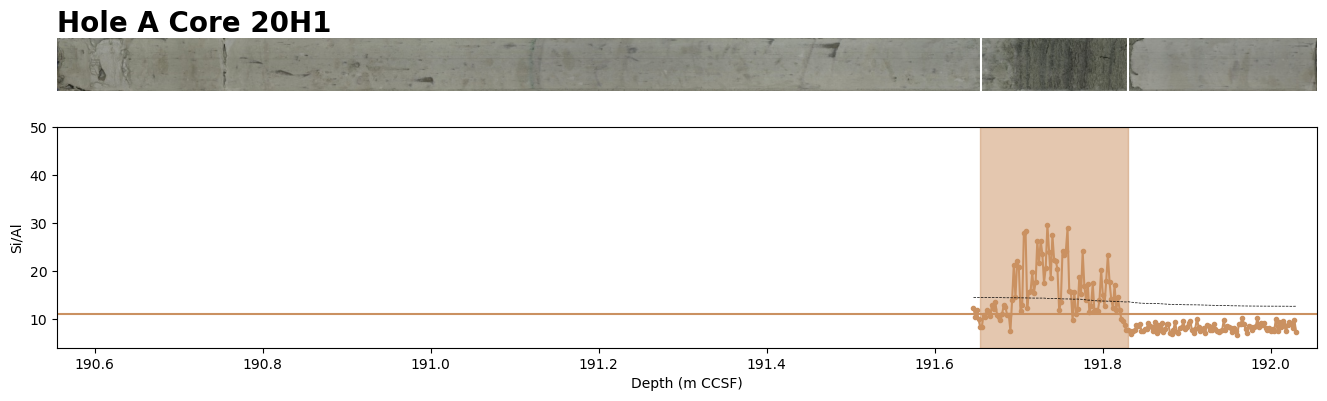

In [295]:
thresh(46,11)

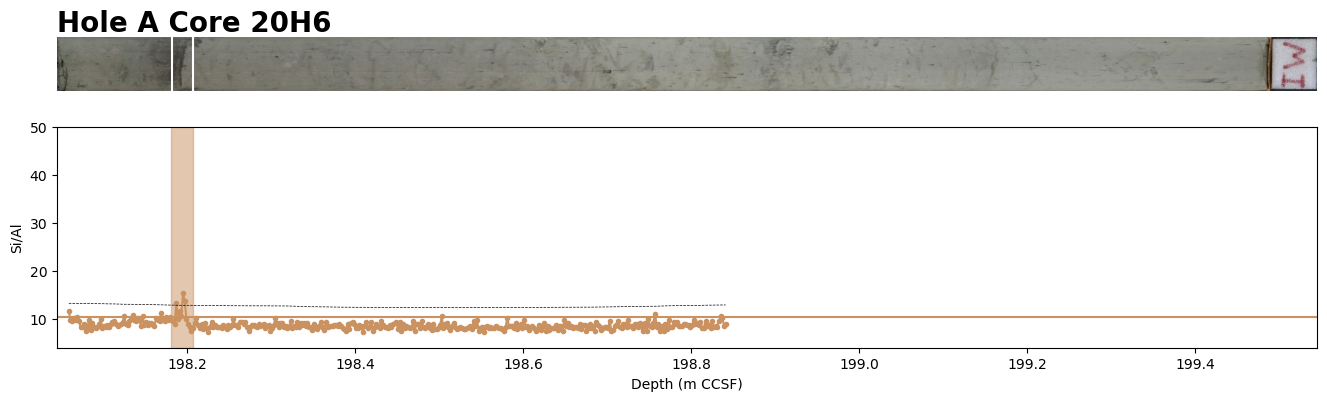

In [296]:
thresh(47,10.5)

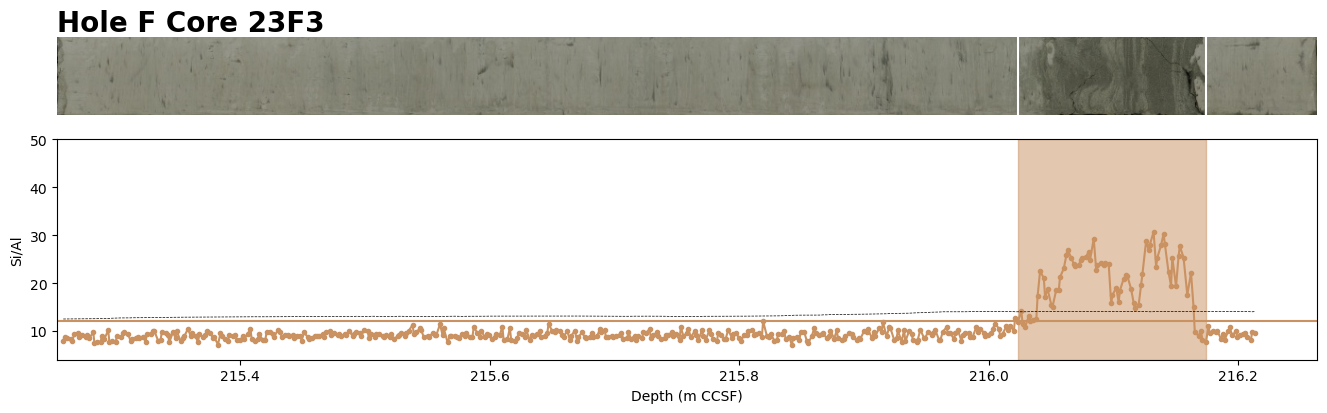

In [297]:
thresh(48,12)

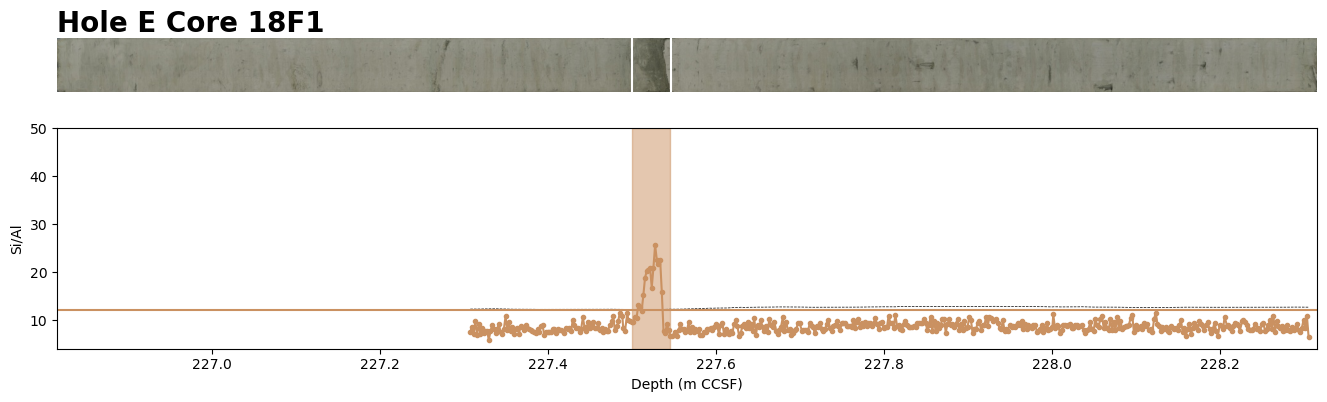

In [298]:
thresh(49,12)

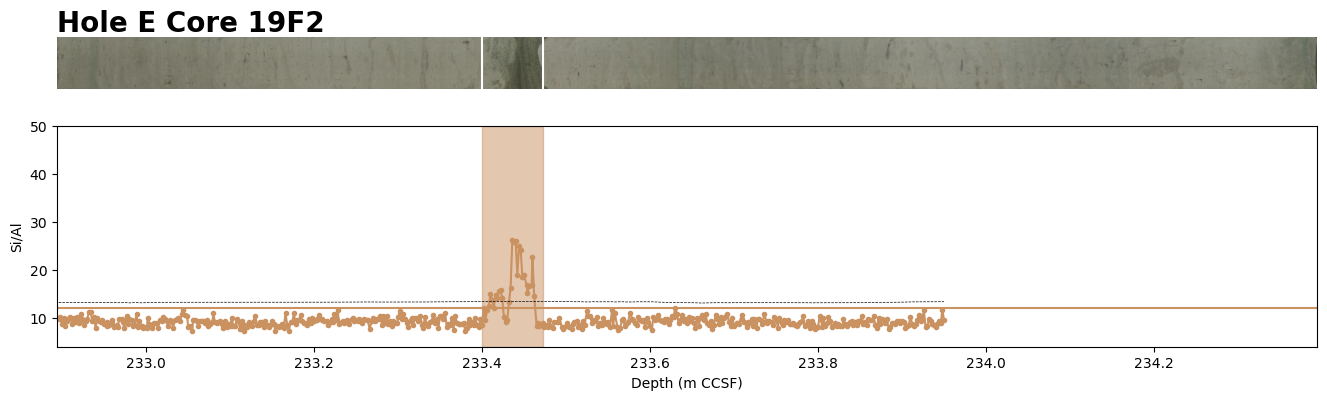

In [299]:
thresh(50,12)

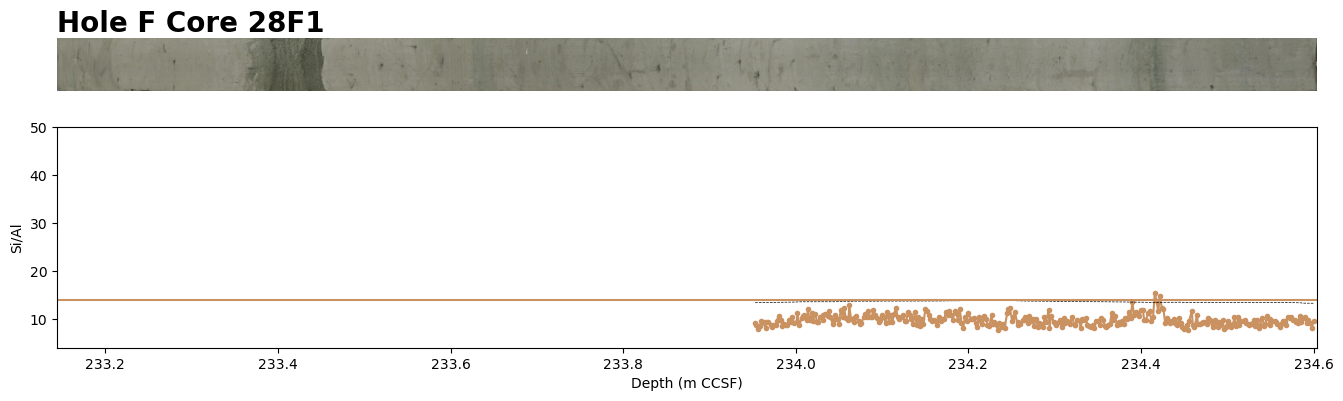

No sound found with this threshold


In [300]:
thresh(51,14)

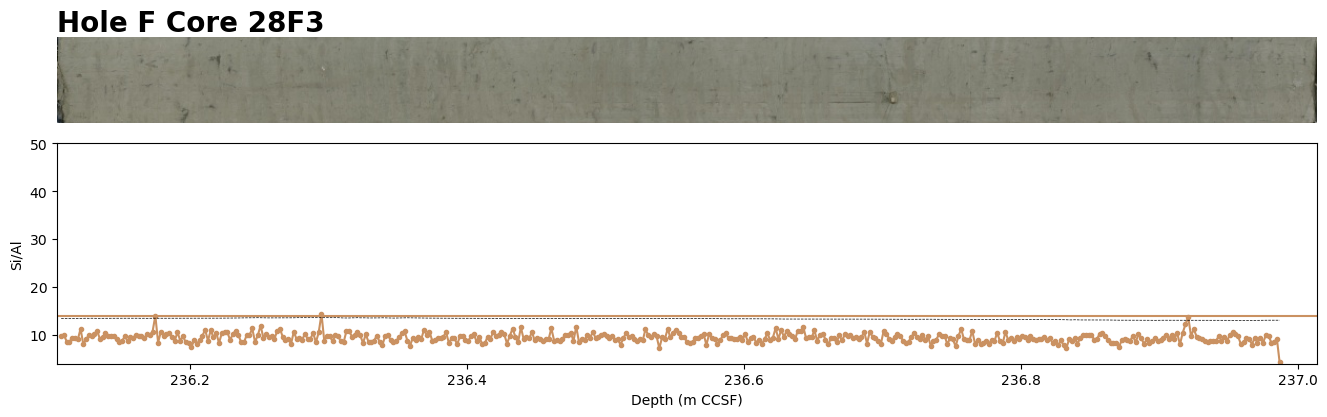

No sound found with this threshold


In [301]:
thresh(52,14)

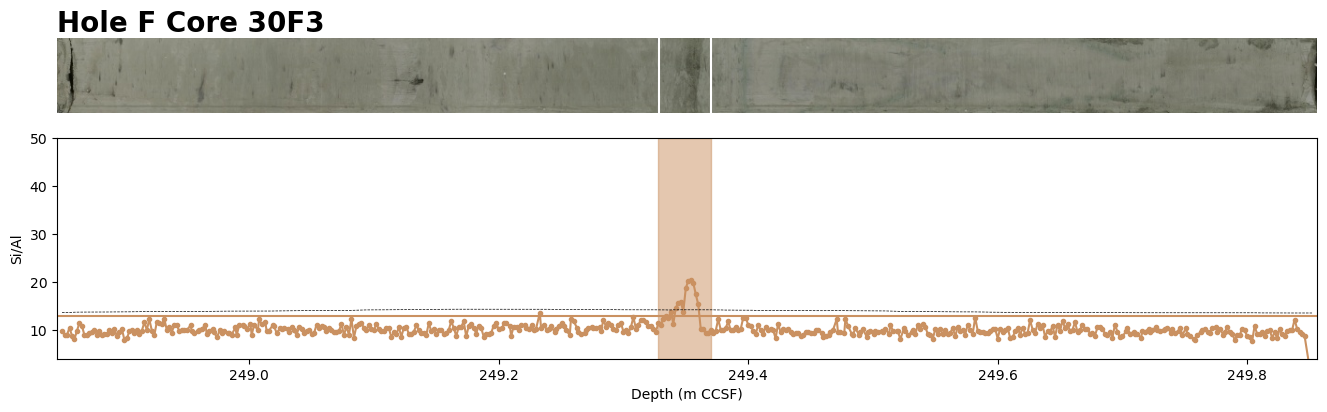

In [302]:
thresh(53,13)

### Manually input sand layer with XRF ratio malfunction due to high water content

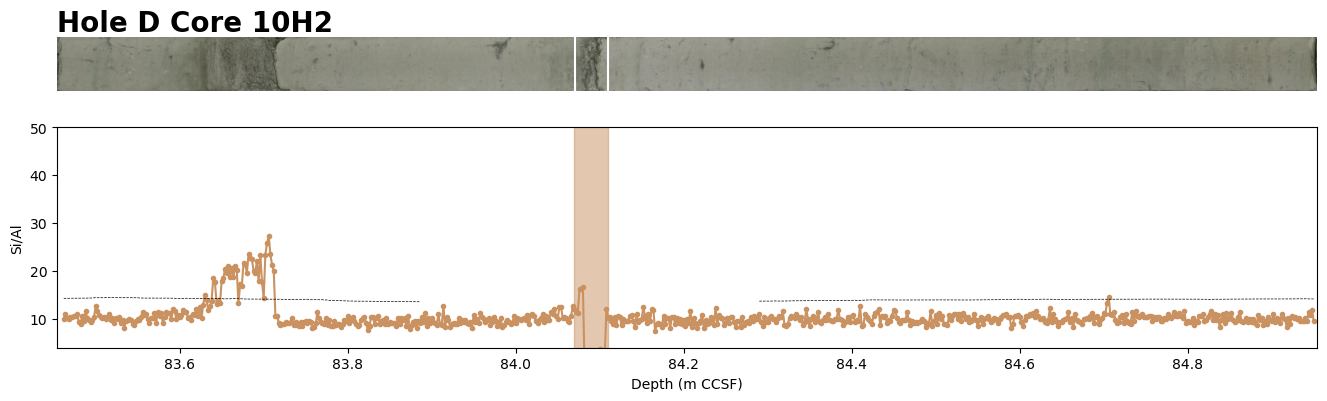

In [306]:
sect=sections[72]

### Set up axis
fig=plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(3, 1, figure=fig,hspace=.1,left=.05,right=.95,top=.95)
ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1:3,:])

### Title
ax1.set_title('Hole '+sect[5]+' Core '+sect[7:],
              fontweight='bold',fontsize=20,pad=0,loc='left')

### Data Management
cols=['Si/Al','RollingMedian+']
data=SiAl.loc[SiAl['SectionLabel']==sect,cols]
SiAl.loc[data.index,'Sand>']=False
top,bottom=section_list.loc[sect,['Top depth CCSF (m)','Bottom depth CCSF (m)']]
pxl_m=np.array(phot[sect]).shape[1]/section_list.loc[sect,'Recovered length (m)']

### Image plot
ax1.imshow(phot[sect])
ax1.axis('off')

### Data plot
data['Si/Al'].plot(ax=ax2,marker='o',ms=3,color=colors[5])
data['RollingMedian+'].plot(ax=ax2,color='k',ls='--',lw=.5)
ax2.set_ylim(4,50)

# ### Data Processing
# potential=data[data>threshold]
# potential['Depth']=potential.index
# potential=potential.dropna().copy()
# if potential.shape[0]==0:
#     for i,a in enumerate([ax2]):
#         a.set_ylabel(cols[i])
#         a.set_xlim(top,bottom)
#         ax2.set_xlabel('Depth (m CCSF)')
#     plt.show()
#     return print('No sound found with this threshold')
# sandzone=potential[potential['Depth']-potential['Depth'].shift()<=.004]
# sandtop=sandzone.index[0]-.01
# sandbottom=sandzone.index[-1]+.01
# sands=data.loc[sandtop:sandbottom].index

### Coloring
ax1.axvline((84.07-top)*pxl_m,c='w')
ax1.axvline((84.11-top)*pxl_m,c='w')
ax2.axvspan(xmin=84.07,xmax=84.11,color=colors[5],alpha=.5)


### Axis management
for i,a in enumerate([ax2]):
    a.set_ylabel(cols[i])
    a.set_xlim(top,bottom)
ax2.set_xlabel('Depth (m CCSF)');

In [307]:
cols=sand_layers.columns
sand_layers.loc[42,cols]=['U1474D_10H2',np.nan,84.07,84.11,4]
sand_layers=sand_layers.sort_values(by='Top depth CCSF (m)')

## Organize Data

In [304]:
sand_layers.loc['U1474F_5H5','Bottom depth CCSF (m)']=sand_layers.loc['U1474F_5H6','Bottom depth CCSF (m)']
sand_layers=sand_layers.drop('U1474F_5H6')

In [305]:
sand_layers=sand_layers.sort_values(by='Top depth CCSF (m)')
sand_layers['Thickness (cm)']=(sand_layers['Bottom depth CCSF (m)']-sand_layers['Top depth CCSF (m)'])*100
sand_layers=sand_layers.reset_index().rename(columns={'index':'SectionLabel'})

## Figure

In [310]:
def thresh(number,threshold):
    sect=SOI[number]
    
    ### Set up axis
    fig=plt.figure(figsize=(14,4))
    gs = gridspec.GridSpec(3, 1, figure=fig,hspace=.1,left=.05,right=.95,top=.95)
    ax1=fig.add_subplot(gs[0,:])
    ax2=fig.add_subplot(gs[1:3,:])
    
    ### Title
    ax1.set_title('Hole '+sect[5]+' Core '+sect[7:],
                  fontweight='bold',fontsize=20,pad=0,loc='left')
    
    ### Data Management
    cols=['Si/Al','RollingMedian+']
    data=SiAl.loc[SiAl['SectionLabel']==sect,cols]
    SiAl.loc[data.index,'Sand>']=False
    top,bottom=section_list.loc[sect,['Top depth CCSF (m)','Bottom depth CCSF (m)']]
    pxl_m=np.array(phot[sect]).shape[1]/section_list.loc[sect,'Recovered length (m)']
    
    ### Image plot
    ax1.imshow(phot[sect])
    ax1.axis('off')
    
    ### Data plot
    data['Si/Al'].plot(ax=ax2,marker='o',ms=3,color=colors[5])
    data['RollingMedian+'].plot(ax=ax2,color='k',ls='--',lw=.5)
    ax2.set_ylim(4,50)
    ax2.axhline(threshold,color=colors[5])
    
    ### Data Processing
    potential=data[data>threshold]
    potential['Depth']=potential.index
    potential=potential.dropna().copy()
    if potential.shape[0]==0:
        for i,a in enumerate([ax2]):
            a.set_ylabel(cols[i])
            a.set_xlim(top,bottom)
            ax2.set_xlabel('Depth (m CCSF)')
        plt.show()
        return print('No sound found with this threshold')
    sandzone=potential[potential['Depth']-potential['Depth'].shift()<=.004]
    sandtop=sandzone.index[0]-.01
    sandbottom=sandzone.index[-1]+.01
    sands=data.loc[sandtop:sandbottom].index
    
    ### Coloring
    ax1.axvline((sandtop-top)*pxl_m,c='w')
    ax1.axvline((sandbottom-top)*pxl_m,c='w')
    ax2.axvspan(xmin=sandtop,xmax=sandbottom,color=colors[5],alpha=.5)

        
    ### Axis management
    for i,a in enumerate([ax2]):
        a.set_ylabel(cols[i])
        a.set_xlim(top,bottom)
    ax2.set_xlabel('Depth (m CCSF)')
    return fig

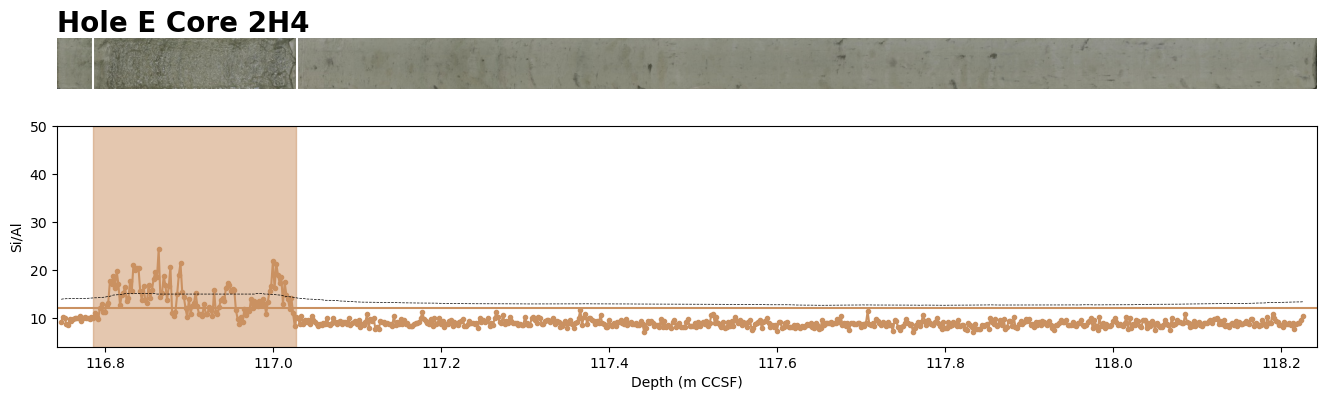

In [311]:
fig=thresh(29,12)
# fig.savefig(figure_path+'sandDemo.png',dpi=300)

## Export Results

In [312]:
sand_layers.to_csv(table_path+'Supplementary Table X Site U1474 Sand Layers.csv',index=False)